# Семинар 1: Системы обычных дифференциальных уравнений: COVID-19. Модель SIR

Рассмотрим модель следующего вида.
Все индивиды в модели могут находиться в одном из четырех состояний:

- Восприимчивый (susceptible, $s$), (индивиды, у кого еще нет имунитета)
- Контактный (exposed, $e$), (заразились, но не стали распространителями, скоро перейдет в инфицированные)
- Инфицированный/больной (infected, $i$), (кратко заболевшие)
- Удаленный, то есть выздоровевший или умерший (removed, $r$). (выздоровевшие с иммунитетом или умершие)

Считается, что контактные не являются распространителями инфекции; выздоровевшие не могут заразиться еще раз.

Уравнения модели:
$$\begin{aligned}
\dot{s}(t) &= -\beta(t) i(t) s(t) \\ 
\dot{e}(t) &= \beta(t) i(t) s(t) - \sigma e(t) \\
\dot{i}(t) &= \sigma e(t) - \gamma i(t) 
\end{aligned}$$
где

* $\beta(t)$ --- скорость передачи,
* $\sigma$ --- норма заболевания,
* $\gamma$ --- норма выбытия (выздоровление или смерть).

Скорость передачи моделируется как $\beta(t) = \gamma R(t)$, где $R(t)$ --- эффективное репродуктивное число.

В данной модели $s,e,i,r$ принимаются равными соответствующим долям от общего населения. Вы могли заметить, что для $r$ отдельного уравнения нет, поскольку структура модели такова, что рост одной переменной на определенную величину приводит к суммарно такому же снижению прочих переменных. Другими словами происходит простое перераспределение между состояниями.

Модель можно переписать в векторной форме:
$$\begin{aligned}
\dot{x} &= F(x, t) \\
x &= \left(s, e, i\right)
\end{aligned}$$
Далее нам понадобится именно векторное представление модели.

Импортируем необходимые модули (на самом деле пакеты, но не будем придираться к терминологии):

* `numpy`: нам будет нужна функция `linspace`, которая формирует массив точек на основе его границ и числа элементов.
* `scipy.integrate`: мы воспользуемся функцией `odeint`, призванной решать обычные дифференциальные уравнения (в первую очередь их системы).
* `matplotlib.pyplot`: тут все очевидно, будем рисовать красивые и не очень графики. После импорта модуля зададим размер выводимых графиков. 

In [2]:
import numpy as np
import scipy.integrate as spi # запомнить, походу реально прикольная штука 
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11, 5)

Создадим массив со значениями $t$, которые будут нужны для графиков. Первое значение равно 0, последнее --- 550, всего массив будет содержать 1000 точек.

In [4]:
time_vec = np.linspace(0, 550, 1000) # создание временного вектора (550 дней - это прогноз на 1,5 года, 1000 точек гладкость)

Функция для удобного построения графиков, которые мы будем получать в процессе решения системы уравнений.
Функция принимает на вход список траекторий, список названий (заголовков) и опциональный массив $t$. Если массив со временем не задать явно, то функция воспользуется созданным нами ранее массивом `time_vec`, и горе вам, если его не будет!

Сначала создадим новый рисунок и добавим в него ось, на которой будем строить график. Де-факто, мы добавляем график на наш рисунок. На один рисунок можно пометстиь несколько осей.
Далее для каждой последовательной пары траектория-заголовок строим ее график на нашей оси.
После этого размещаем легенду в верхнем левом углу.

Ну и выводим рисунок.

In [5]:
def plot_paths(paths, labels, times=time_vec): # (список массивов траекторий , + заголовки + вектор времени)
    fig = plt.figure()
    ax = fig.add_subplot() # подграфик на фигуру

    for path, label in zip(paths, labels): # для каждой пары...
        ax.plot(times, path, label=label)

    ax.legend(loc="upper left")
    plt.show()

## Начальные условия и определение модели

Предположим, что население некоторой \<\<условной\>\> страны составляет 330 млн человек.

In [6]:
population = 3.3e8

Коэффициенты $\gamma$ и $\sigma$ считаются природными константами.
Считается, что время болезни составляет в среднем 18 дней, а инкубационный период --- 5.2 дня.
То есть каждый день выздоравливает примерно восемнадцатая часть больных, а заболевает, соответственно, 10/52 контактных.

In [8]:
gamma = 1 / 18 # норма заболевания
sigma = 1 / 5.2 # норма выбытия 

Вспомним приведенное выше векторное представление системы $\dot{x} = F(x, t)$.
Реализуем функцию `F`.
На вход она принимает список текущих значений переменных модели и время.
Также можно передать ей опциональный аргумент, задающий эффективное репродуктивное число $R(t)$, по умолчанию равный константе 1,6.

Сначала для пущего удобства распакуем `x` в три отдельных значения `s`, `e` и `i`.
Затем немного магии: мы формируем значение `beta` в зависимости от того, является ли `R0` функцией или нет.
Если да, то `beta` будет равно произведению `gamma` на значение `R0` в момент времени `t`; если нет --- то тоже произведению, но уже просто двух констант.

Затем посчитаем значения производных в левой части системы при помощи уравнений системы.

In [9]:
def F(x, t, R0=1.6): # (если решать ОДУ - это правая часть, где x-вектор, t-время)
    s, e, i = x

    beta = R0(t) * gamma if callable(R0) else R0 * gamma

    ds = -beta * i * s # (производная S)
    de = beta * i * s - sigma * e # (производная e)
    di = sigma * e - gamma * i # (производная i)

    return ds, de, di

Для работы функции `odeint` нам нужно явно задать начальные значения для интересующих нас переменных.

In [ ]:
i0 = 25000 / population # похоже на начальную долю 25к человек из 330 лямов 
e0 = 3 * i0 # Начальная доля контактных 
s0 = 1 - i0 - e0 # остаток 

## Функция для решения системы уравнений

Определим функцию, решающую систему.
Это не обязательно, но мы далее будем решать систему для различных значений $R$, так что отдельная функция будет удобной.

Функция `odeint` принимает на вход три обязательных аргумента:

* Функцию для интегрирования. Данная функция должна принимать на вход два аргумента --- `x` и `t`, строго в этом порядке.
* Вектор начальных значений.
* Массив со временем.

Наша функция будет принимать на вход 3 аргумента:

* `R0`,
* Массив со временем,
* Вектор начальных значений.

Данный набор аргументов делает определенную выше функцию `F` не подходящей для целей интегрирования (почему, кстати?), поэтому определим вложенную функцию `G`, удовлетворяющую нашим задачам.
`odeint` возвращает результаты работы в виде матрицы, где **по столбцам** располагаются траектории для наших переменных. Можно разобрать матрицу вручную, а можно воспользоваться возможностями распаковки, транспонировав матрицу.

In [11]:
def solve_path(R0, time_vec, x0=(s0, e0, i0)):
    def G(x, t): # функция подгонка 
        return F(x, t, R0)

    s_path, e_path, i_path = spi.odeint(G, x0, time_vec).transpose() # решает ОДУ, возвращает матрицу
    return s_path, e_path, i_path # Возвращает траектории

## Эксперименты

### Постоянное эффективное репродуктивное число

Решим нашу систему для случая постоянного репродуктивного числа.
Рассмотрим 6 вариантов: от 1,6 до 3.

Для каждого случая сохраним траетории числа инфицированных и совокупного числа инфицированных и исключенных.

In [12]:
R0_vals = np.linspace(1.6, 3.0, 6)
labels = [f"$R_0 = {r:.2f}$" for r in R0_vals]

i_paths, c_paths = [], []

for R in R0_vals:
    res = solve_path(R, time_vec)
    i_paths.append(res[2])
    c_paths.append(1 - res[0] - res[1])

Построим графики числа инфицированных...

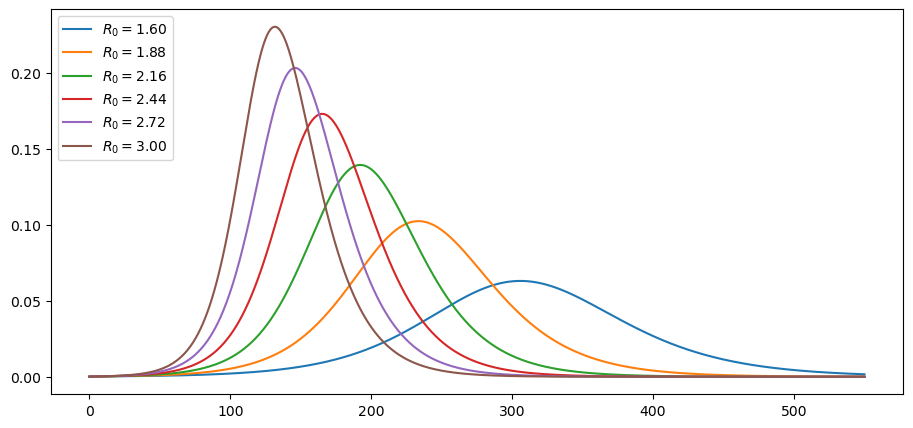

In [13]:
plot_paths(i_paths, labels)

... и совокупного числа инфицированных и переболевших.

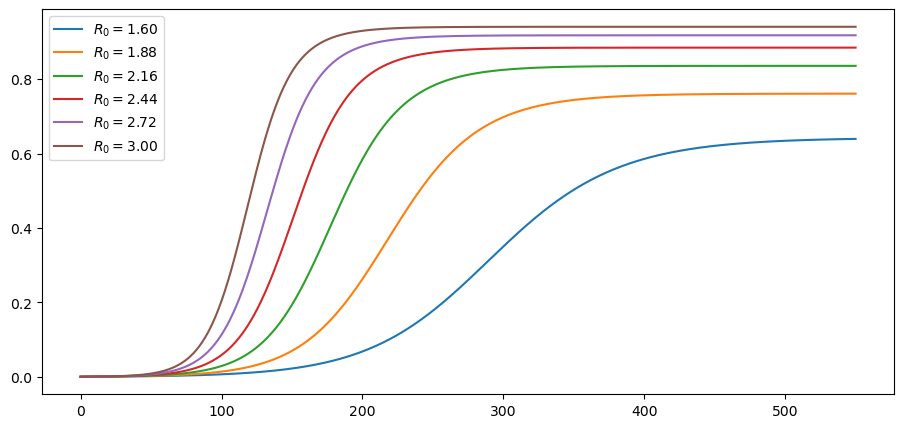

In [15]:
plot_paths(c_paths, labels) # график отображает траектории совокупного числа инфицированных и удалённых

### Переменное эффективное репродуктивное число

Пусть репродуктивное число снижается с 3 до 1.6 с некоторой скоростью $\eta$:
$$ R(t) = R_0 \exp(-\eta t) + R_\infty (1 - \exp(-\eta t)) $$

In [16]:
def R0_func(t, R_start=3, R_finish=1.6, eta=1.0):
    return R_start * np.exp(-eta * t) + R_finish * (1 - np.exp(-eta * t))

In [17]:
eta_vals = [1 / 5, 1 / 10, 1 / 20, 1 / 50, 1 / 100]
labels = [rf"$\eta = {eta:.2f}$" for eta in eta_vals]

Посмотрим на графики $R(t)$.

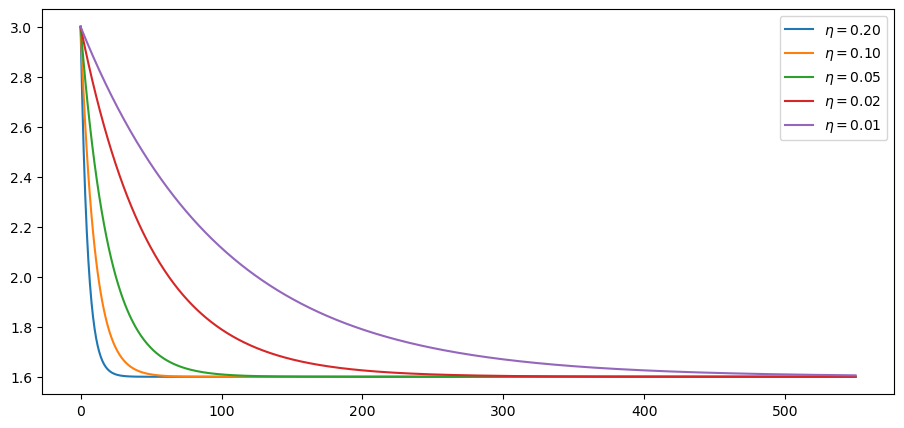

In [18]:
fig, ax = plt.subplots()

for eta, label in zip(eta_vals, labels):
    ax.plot(time_vec, R0_func(time_vec, eta=eta), label=label)

ax.legend()
plt.show()

Решим систему для всех значений скорости убывания репродуктивного числа.

In [19]:
i_paths, c_paths = [], []

for eta in eta_vals:

    def R(t):
        return R0_func(t, eta=eta)

    res = solve_path(R, time_vec)
    i_paths.append(res[2])
    c_paths.append(1 - res[0] - res[1])

Построим графики.

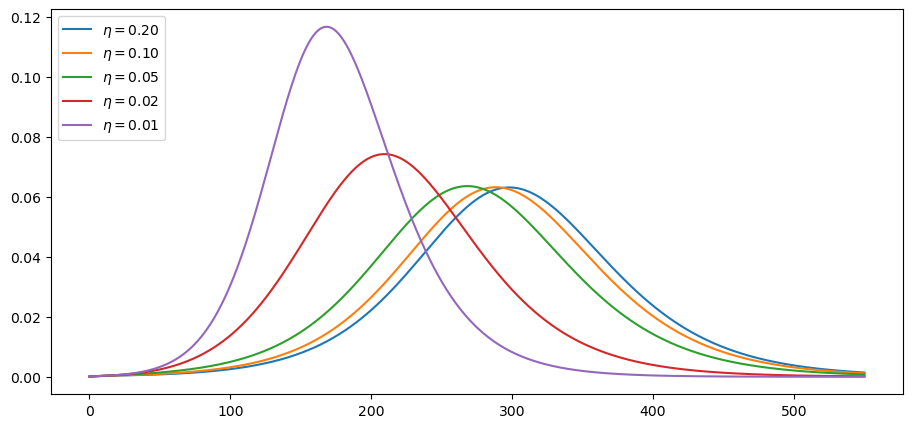

In [21]:
plot_paths(i_paths, labels)

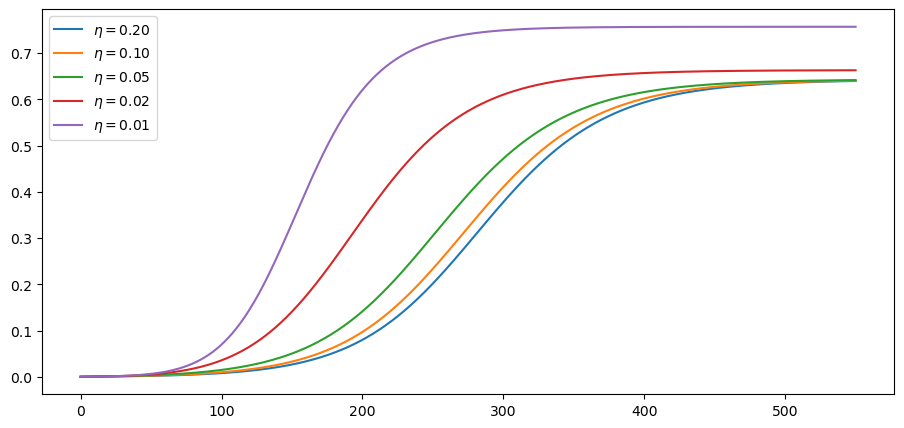

In [22]:
plot_paths(c_paths, labels)

### Локдауны

Смоделируем локдауны следующим образом.
Пусть до какого-то момента времени все сидят по домам.
В этот период репродуктивное число принимается равным 0,5.
После окончания локдауна это число подскакивает до 2.
Это реализуется в виде простой функции.

In [23]:
R_paths = (lambda t: 0.5 if t < 30 else 2, lambda t: 0.5 if t < 120 else 2)

labels = ["Короткий локдаун", "Длинный локдаун"]

i_paths, c_paths = [], []

for R in R_paths:
    res = solve_path(R, time_vec, x0=(s0, e0, i0))
    i_paths.append(res[2])
    c_paths.append(1 - res[0] - res[1])

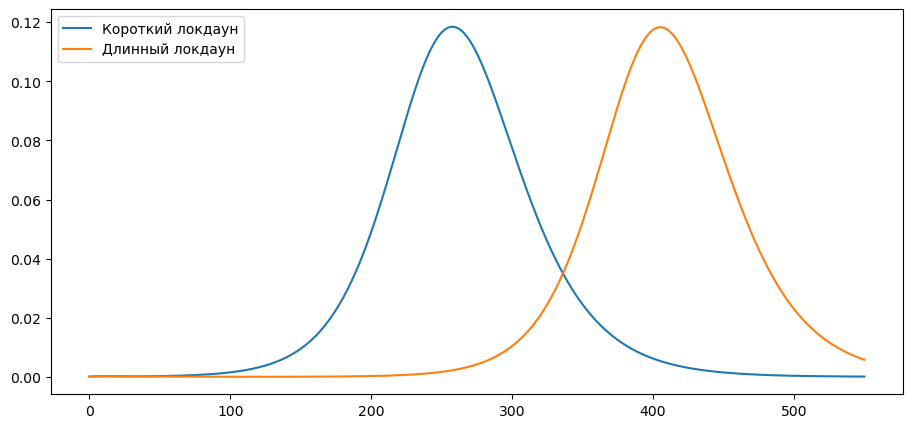

In [24]:
plot_paths(i_paths, labels)

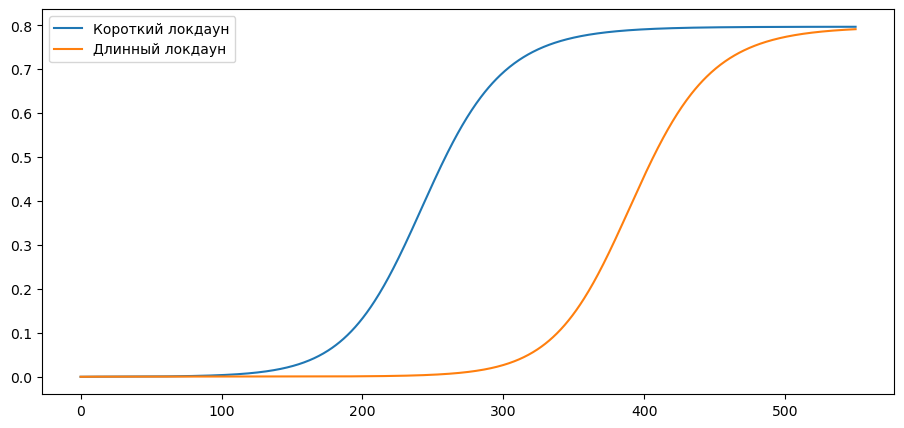

In [25]:
plot_paths(c_paths, labels)

Оценим число смертельных случаев, предположив, что смертность составляет 1%.

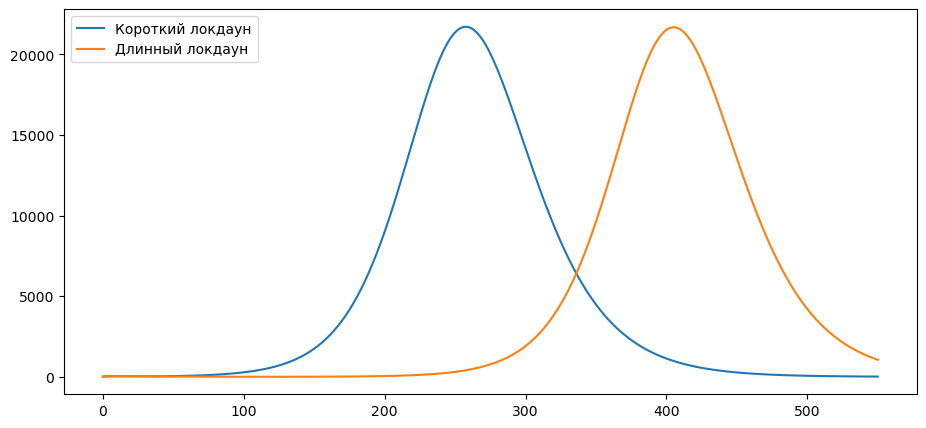

In [26]:
nu = 0.01
dead = [infected * nu * gamma * population for infected in i_paths]
plot_paths(dead, labels)

# Задание 1: 

Модифицируйте модель SIR для учета (Опишите принцип модификации, проведите симуляции и опишите полученные результаты)

1. возможности повторного заражения.

2. заразности контактных.



## Идея модификации повторного заражения 

На паре у нас было 3 уравнения, где 4 уравнение (подразумевалось), но не было записано и его вид:

$$
\dot{r}(t) = \gamma i(t)
$$

и следовательно у нас существует r(t) и вычисляется как 

$$
r(t) = 1 - s(t) - e(t) - i(t)
$$

те (сумма всех долей = 1) 

Хм... и тогда получается, что люди имеют вечный иммунитет? Бред, хотя для упрощения модели - супер и тут без вопросов. 

Что делать? Нам в этом уравнении не хватает такой переменной, которая показывает/зацикливает из r в s те мысль такая: ***выздоровевшие теряют иммунитет со временем*** и это своего рода можно рассматривать как нечто циклическое

Как теперь выглядят эти уравнения? 

$$
\begin{aligned}
\dot{s}(t) &= -\beta\, i(t)\, s(t) + \lambda\, r(t) \\
\dot{e}(t) &= \beta\, i(t)\, s(t) - \sigma\, e(t) \\
\dot{i}(t) &= \sigma\, e(t) - \gamma\, i(t) \\
\dot{r}(t) &= \gamma\, i(t) - \lambda\, r(t)
\end{aligned}
$$

Что добавилось? 

λ — норма потери иммунитета (1/среднее время иммунитета, 1/365 дней для годичного иммунитета, промежуток год, выбран на основе действия вакцин и рекомендованный период ревакцинации 6-12 месяцев, но для удобства взял 1 год)

Кратко: модель становится циклической, эпидемия может повторяться волнами, если λ > 0. Если λ = 0, модель сводится к семинарской (этот прием я буду использовать часто тк не хочу писать писать неуниверсальный код, я буду в большинстве случаев занулять переменную)


In [76]:
lambda_ = 1 / 365  # ввели переменную (норма потери иммунитета)
# вырубил переменную, но в другом пункте мы узнаем ее значение (придадим загадочности)
beta_e_factor = 0  # это коэффициент заразности контактных
r0 = 0 # Тип в начале еще никто не заболел 
x0_1 = (s0, e0, i0, r0) # кортеж начальных условий для системы

In [77]:
def F_1(x, t, R0=1.6): # идея стырена с семинара 
    s, e, i, r = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    beta_e = beta_e_factor * beta
    ds = -beta * i * s - beta_e * e * s + lambda_ * r
    de = beta * i * s + beta_e * e * s - sigma * e
    di = sigma * e - gamma * i
    dr = gamma * i - lambda_ * r
    return ds, de, di, dr

In [ ]:
def solve_path_1(R0, time_vec, x0=x0_1): # тоже стырино с семинара 
    def G(x, t):
        return F_1(x, t, R0)
    solution = spi.odeint(G, x0, time_vec)
    s_path, e_path, i_path, r_path = solution.transpose()
    return s_path, e_path, i_path, r_path

In [ ]:
i_paths_1, c_paths_1 = [], [] # Симуляции
for R in R0_vals:
    s, e, i, r = solve_path_1(R, time_vec)
    i_paths_1.append(i)
    c_paths_1.append(i + r)

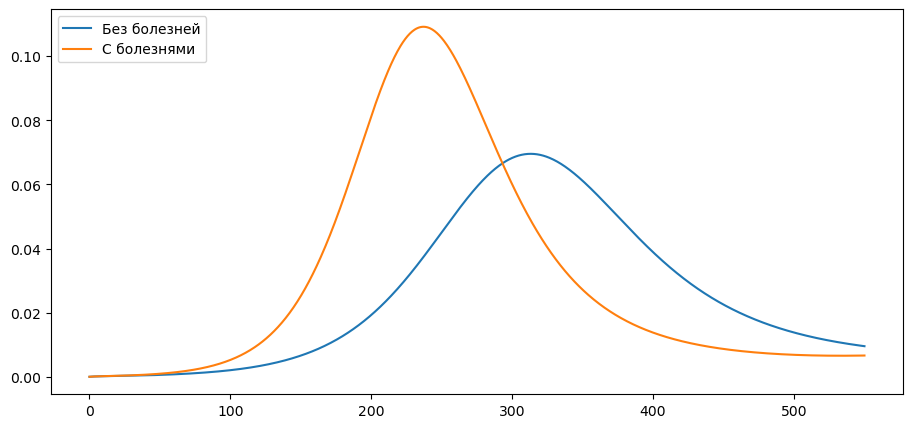

In [80]:
# Графики
plot_paths(i_paths_1, labels)  # i(t)

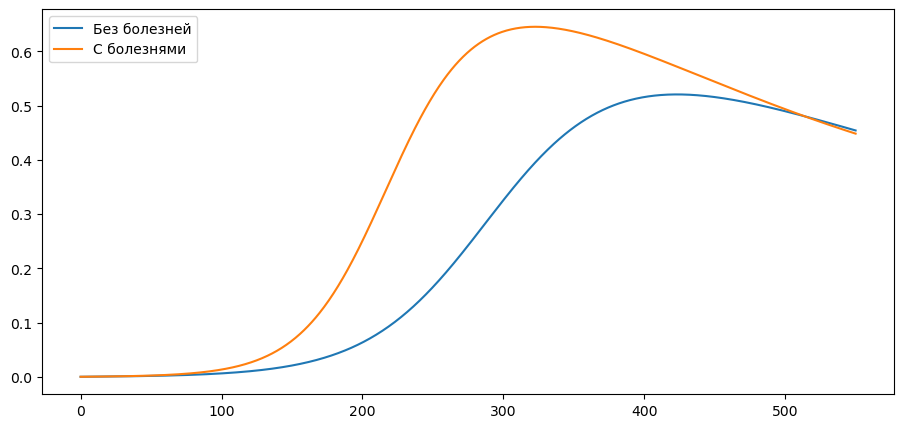

In [81]:
plot_paths(c_paths_1, labels)  # c(t)

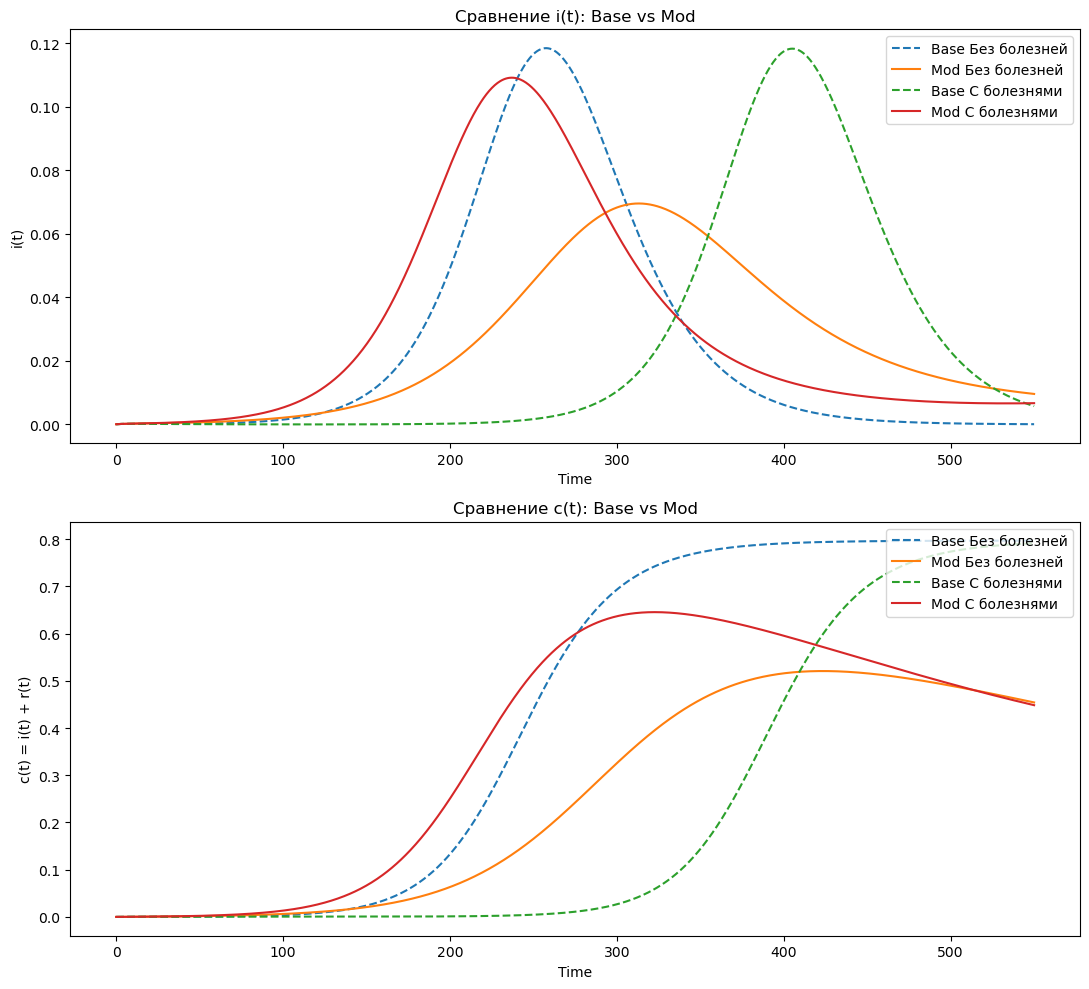

In [86]:
# Сравнение на одном графике (для i(t) и c(t), с суффиксами base/mod)
fig, ax = plt.subplots(2, 1, figsize=(11, 10))

# График для i(t)
for idx, R_label in enumerate(labels):
    ax[0].plot(time_vec, i_paths[idx], label=f"Base {R_label}", linestyle='--')
    ax[0].plot(time_vec, i_paths_1[idx], label=f"Mod {R_label}", linestyle='-')
ax[0].set_title("Сравнение i(t): Base vs Mod")
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("i(t)")

# График для c(t) = i + r
for idx, R_label in enumerate(labels):
    ax[1].plot(time_vec, c_paths[idx], label=f"Base {R_label}", linestyle='--')
    ax[1].plot(time_vec, c_paths_1[idx], label=f"Mod {R_label}", linestyle='-')
ax[1].set_title("Сравнение c(t): Base vs Mod")
ax[1].legend(loc="upper right")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("c(t) = i(t) + r(t)")

plt.tight_layout()
plt.show()

## Идея заразности контактных 

В этой части нас интересуют "e" те контактные, по условию у нас дана только скорость изменения для контактных. Это надо как-то исправлять. Для исправления этого недоразумения введем $-\beta_e$ ***спойлер, мы это уже видели выше, я занулял этот параметр***

И для этого надо модифицировать наши уравнения до вида (я тут запутался в Latex):

\[
\begin{cases}
\dot{s} = -\beta i s - \beta_e e s \\
\dot{e} = \beta i s + \beta_e e s - \sigma e \\
\dot{i} = \sigma e - \gamma i \\
\dot{r} = 1 - s - e - i
\end{cases}
\]

β_e - скорость передачи 

$-\beta_e e s$ в $\dot{s}$ - скорость заражения восприимчивых от экспонированных

$+\beta_e e s$ - приток новых экспонированных — тех, кто заразился от экспонированных


In [ ]:
# Параметры
lambda_ = 0        # Выключено
beta_e_factor = 0.5  # Включено

# Начальные условия
x0_2 = (s0, e0, i0, r0)

# Функция F
def F_2(x, t, R0=1.6):
    s, e, i, r = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    beta_e = beta_e_factor * beta
    ds = -beta * i * s - beta_e * e * s + lambda_ * r
    de = beta * i * s + beta_e * e * s - sigma * e
    di = sigma * e - gamma * i
    dr = gamma * i - lambda_ * r
    return ds, de, di, dr

# Solve
def solve_path_2(R0, time_vec, x0=x0_2):
    def G(x, t):
        return F_2(x, t, R0)
    solution = spi.odeint(G, x0, time_vec)
    s_path, e_path, i_path, r_path = solution.transpose()
    return s_path, e_path, i_path, r_path



In [ ]:
# Симуляции
i_paths_2, c_paths_2 = [], []
for R in R0_vals:
    s, e, i, r = solve_path_2(R, time_vec)
    i_paths_2.append(i)
    c_paths_2.append(i + r)

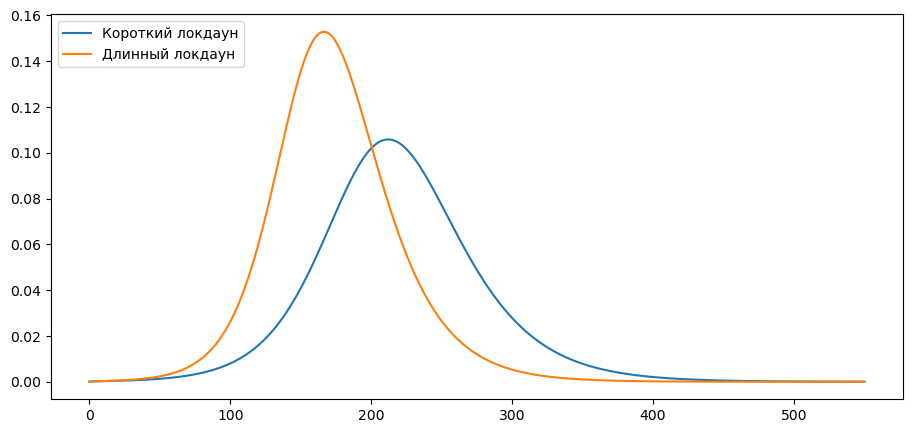

In [ ]:
# Графики
plot_paths(i_paths_2, labels)  # i(t)


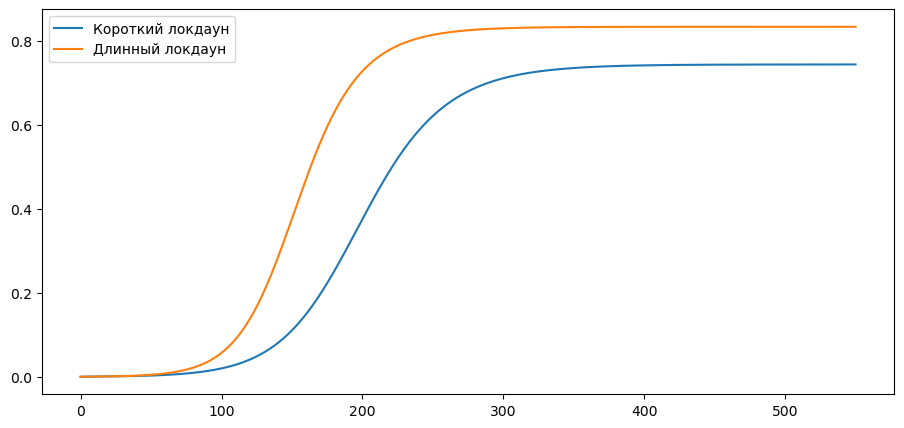

In [41]:
plot_paths(c_paths_2, labels)  # c(t)

## Далее я относительно развлекаюсь с графиками 

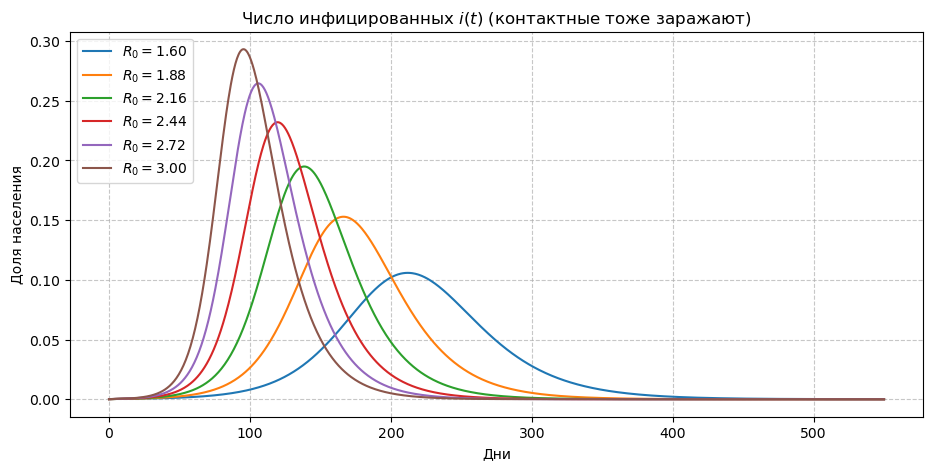

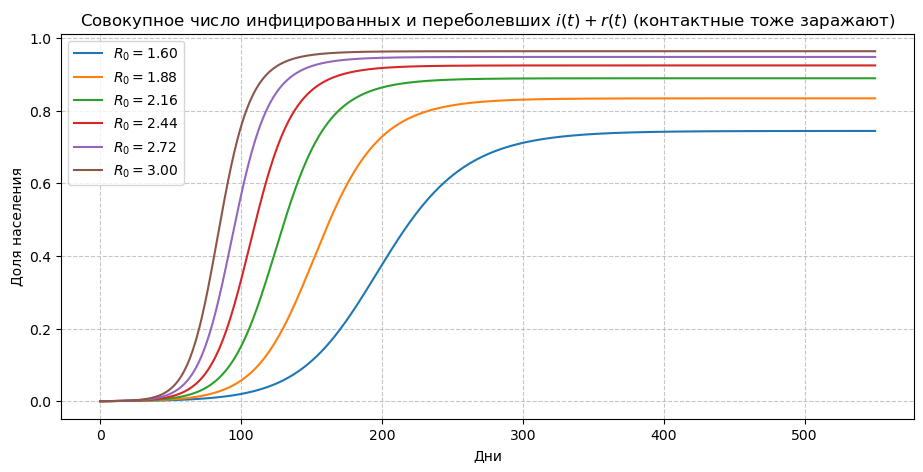

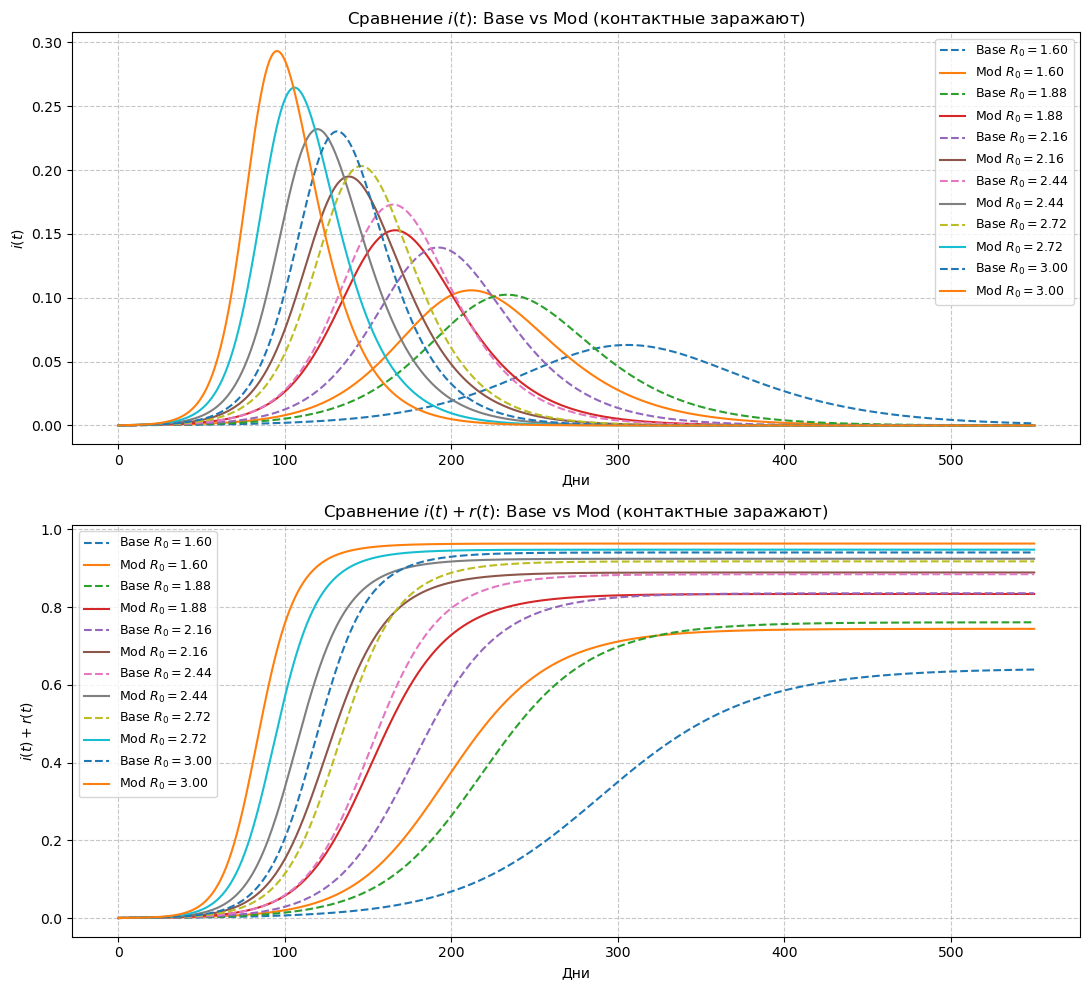

In [ ]:


# Параметры
gamma = 1 / 18
sigma = 1 / 5.2
lambda_ = 0           # Потеря иммунитета отключена
beta_e_factor = 0.5   # Контактные тоже заражают

# Начальные условия
population = 3.3e8
i0 = 25000 / population
e0 = 3 * i0
s0 = 1 - i0 - e0
r0 = 0
x0_2 = (s0, e0, i0, r0)

R0_vals = np.linspace(1.6, 3.0, 6)
labels = [f"$R_0 = {r:.2f}$" for r in R0_vals]
time_vec = np.linspace(0, 550, 1000)

def F_2(x, t, R0=1.6):
    s, e, i, r = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    beta_e = beta_e_factor * beta
    ds = -beta * i * s - beta_e * e * s + lambda_ * r
    de = beta * i * s + beta_e * e * s - sigma * e
    di = sigma * e - gamma * i
    dr = gamma * i - lambda_ * r
    return ds, de, di, dr

def solve_path_2(R0, time_vec, x0=x0_2):
    def G(x, t):
        return F_2(x, t, R0)
    s_path, e_path, i_path, r_path = spi.odeint(G, x0, time_vec).transpose()
    return s_path, e_path, i_path, r_path

# Симуляции
i_paths_2, c_paths_2 = [], []
for R in R0_vals:
    s, e, i, r = solve_path_2(R, time_vec)
    i_paths_2.append(i)
    c_paths_2.append(i + r)

# Графики
def plot_paths(paths, labels, times=time_vec, title=""):
    fig = plt.figure()
    ax = fig.add_subplot()
    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)
    ax.legend(loc="upper left")
    ax.set_xlabel("Дни")
    ax.set_ylabel("Доля населения")
    if title:
        ax.set_title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_paths(i_paths_2, labels, title="Число инфицированных $i(t)$ (контактные тоже заражают)")
plot_paths(c_paths_2, labels, title="Совокупное число инфицированных и переболевших $i(t)+r(t)$ (контактные тоже заражают)")

# Сравнение с базовой моделью
def F_base(x, t, R0=1.6):
    s, e, i = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    ds = -beta * i * s
    de = beta * i * s - sigma * e
    di = sigma * e - gamma * i
    return ds, de, di

def solve_path_base(R0, time_vec, x0=(s0, e0, i0)):
    def G(x, t):
        return F_base(x, t, R0)
    s_path, e_path, i_path = spi.odeint(G, x0, time_vec).transpose()
    return s_path, e_path, i_path

i_paths_base, c_paths_base = [], []
for R in R0_vals:
    s, e, i = solve_path_base(R, time_vec)
    i_paths_base.append(i)
    c_paths_base.append(1 - s - e)

# Сравнительный график
fig, ax = plt.subplots(2, 1, figsize=(11, 10))
for idx, R_label in enumerate(labels):
    ax[0].plot(time_vec, i_paths_base[idx], '--', label=f"Base {R_label}")
    ax[0].plot(time_vec, i_paths_2[idx], '-', label=f"Mod {R_label}")
ax[0].set_title("Сравнение $i(t)$: Base vs Mod (контактные заражают)")
ax[0].legend(fontsize=9)
ax[0].set_xlabel("Дни")
ax[0].set_ylabel("$i(t)$")
ax[0].grid(True, linestyle='--', alpha=0.7)

for idx, R_label in enumerate(labels):
    ax[1].plot(time_vec, c_paths_base[idx], '--', label=f"Base {R_label}")
    ax[1].plot(time_vec, c_paths_2[idx], '-', label=f"Mod {R_label}")
ax[1].set_title("Сравнение $i(t)+r(t)$: Base vs Mod (контактные заражают)")
ax[1].legend(fontsize=9)
ax[1].set_xlabel("Дни")
ax[1].set_ylabel("$i(t)+r(t)$")
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Комбинированная модель
(обе "особенности" вместе)

## Идея 

Добавляем потерю иммунитета λ и заразность β_e 

И все финально выглядит вооооооот так: 

\[
\begin{cases}
\dot{s} = -\beta i s - \beta_e e s + \lambda r \\
\dot{e} = \beta i s + \beta_e e s - \sigma e \\
\dot{i} = \sigma e - \gamma i \\
\dot{r} = \gamma i - \lambda r
\end{cases}
\]

Думаю, в объяснениях я больше не нуждаюсь, тк все "новые" переменные я объяснял выше:)

In [ ]:
# Параметры
lambda_ = 1 / 365  # Включено
beta_e_factor = 0.5  # Включено

# Начальные условия
x0_3 = (s0, e0, i0, r0)

# Функция F
def F_3(x, t, R0=1.6):
    s, e, i, r = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    beta_e = beta_e_factor * beta
    ds = -beta * i * s - beta_e * e * s + lambda_ * r
    de = beta * i * s + beta_e * e * s - sigma * e
    di = sigma * e - gamma * i
    dr = gamma * i - lambda_ * r
    return ds, de, di, dr

# Solve
def solve_path_3(R0, time_vec, x0=x0_3):
    def G(x, t):
        return F_3(x, t, R0)
    solution = spi.odeint(G, x0, time_vec)
    s_path, e_path, i_path, r_path = solution.transpose()
    return s_path, e_path, i_path, r_path

In [ ]:
# Симуляции
i_paths_3, c_paths_3 = [], []
for R in R0_vals:
    s, e, i, r = solve_path_3(R, time_vec)
    i_paths_3.append(i)
    c_paths_3.append(i + r)

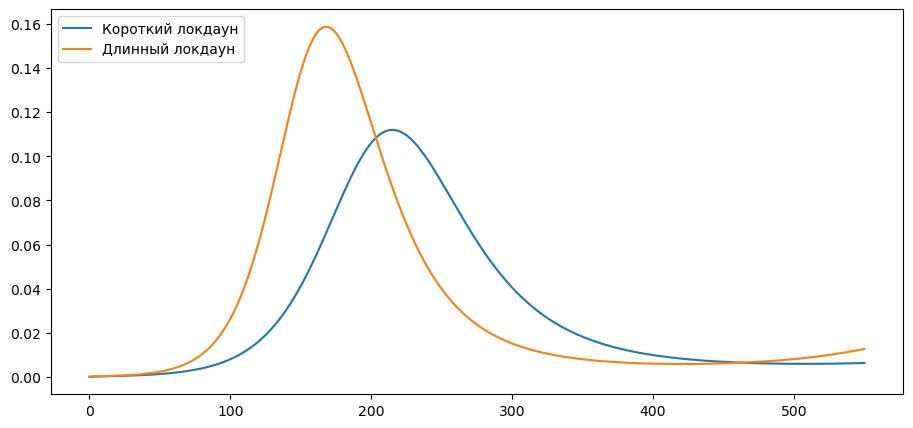

In [ ]:
# Графики
plot_paths(i_paths_3, labels)  # i(t)

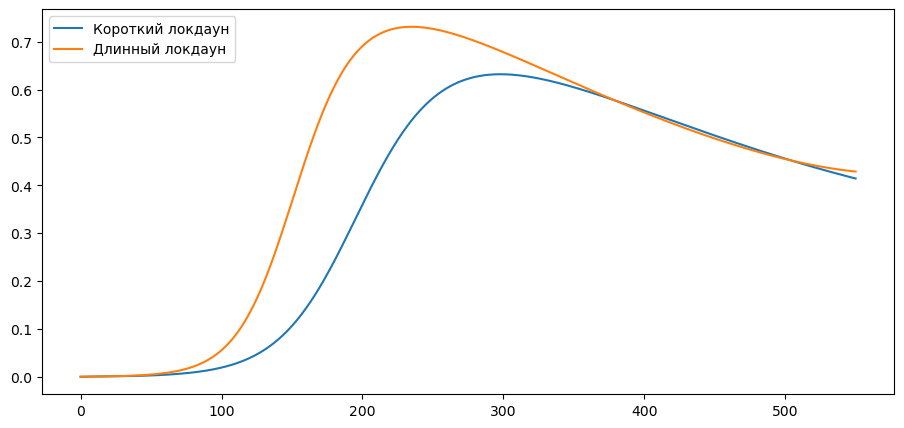

In [ ]:
plot_paths(c_paths_3, labels)  # c(t)

## Внизу для себя

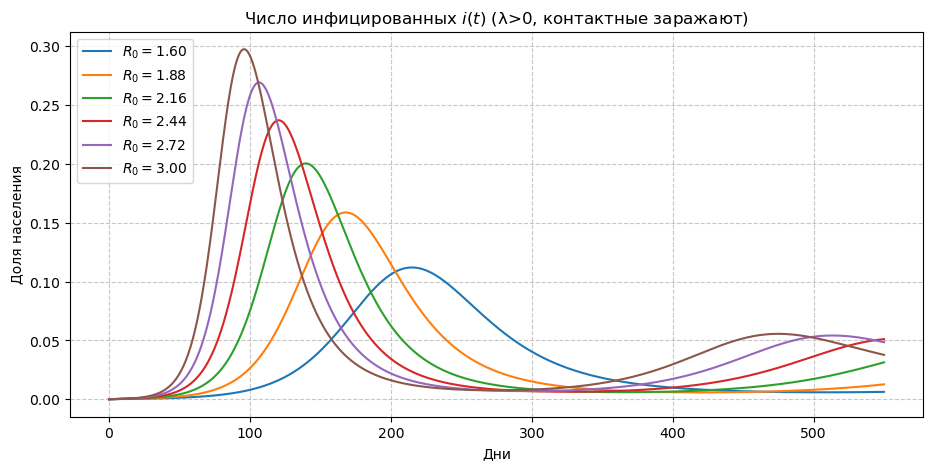

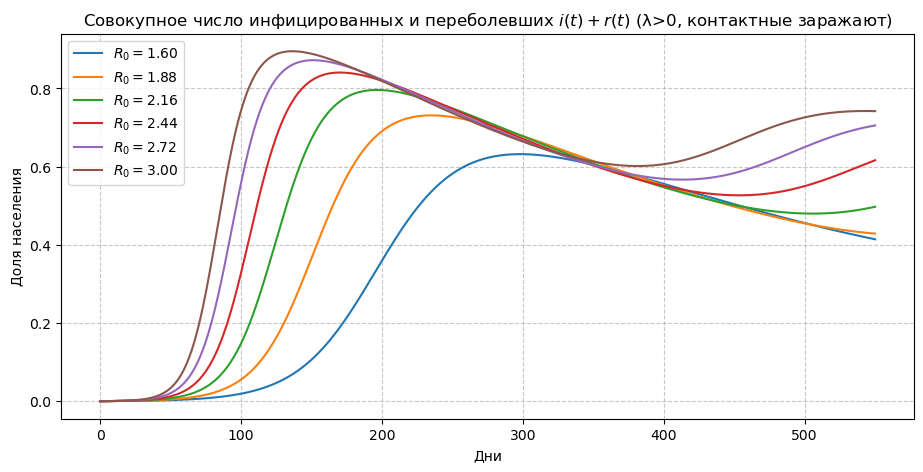

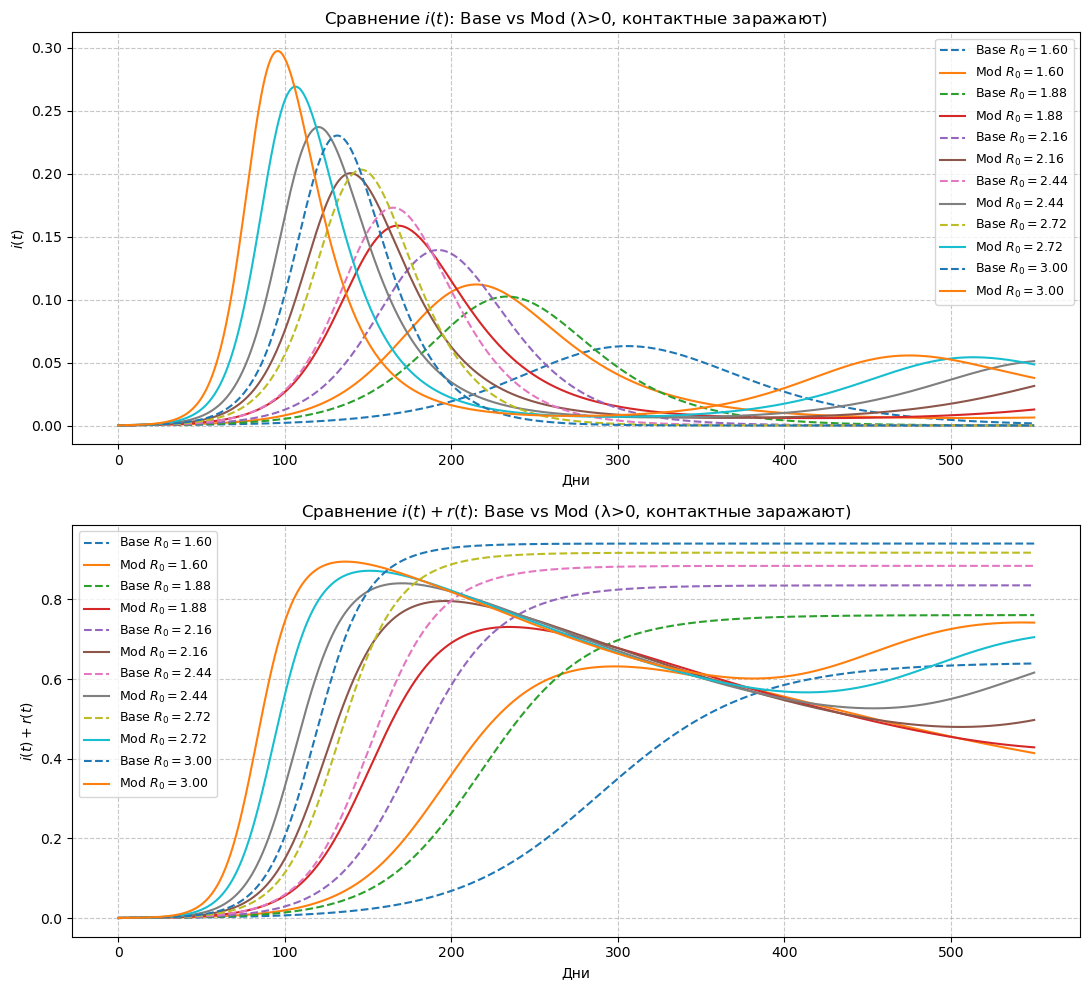

In [51]:
# --- Комбинированная модель: и потеря иммунитета, и заразность контактных ---

# Параметры
gamma = 1 / 18
sigma = 1 / 5.2
lambda_ = 1 / 365      # Потеря иммунитета (1 год)
beta_e_factor = 0.5    # Контактные тоже заражают

# Начальные условия
population = 3.3e8
i0 = 25000 / population
e0 = 3 * i0
s0 = 1 - i0 - e0
r0 = 0
x0_3 = (s0, e0, i0, r0)

R0_vals = np.linspace(1.6, 3.0, 6)
labels = [f"$R_0 = {r:.2f}$" for r in R0_vals]
time_vec = np.linspace(0, 550, 1000)

def F_3(x, t, R0=1.6):
    s, e, i, r = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    beta_e = beta_e_factor * beta
    ds = -beta * i * s - beta_e * e * s + lambda_ * r
    de = beta * i * s + beta_e * e * s - sigma * e
    di = sigma * e - gamma * i
    dr = gamma * i - lambda_ * r
    return ds, de, di, dr

def solve_path_3(R0, time_vec, x0=x0_3):
    def G(x, t):
        return F_3(x, t, R0)
    s_path, e_path, i_path, r_path = spi.odeint(G, x0, time_vec).transpose()
    return s_path, e_path, i_path, r_path

# Симуляции
i_paths_3, c_paths_3 = [], []
for R in R0_vals:
    s, e, i, r = solve_path_3(R, time_vec)
    i_paths_3.append(i)
    c_paths_3.append(i + r)

# Графики
def plot_paths(paths, labels, times=time_vec, title=""):
    fig = plt.figure()
    ax = fig.add_subplot()
    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)
    ax.legend(loc="upper left")
    ax.set_xlabel("Дни")
    ax.set_ylabel("Доля населения")
    if title:
        ax.set_title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_paths(i_paths_3, labels, title="Число инфицированных $i(t)$ (λ>0, контактные заражают)")
plot_paths(c_paths_3, labels, title="Совокупное число инфицированных и переболевших $i(t)+r(t)$ (λ>0, контактные заражают)")

# Сравнение с базовой моделью
def F_base(x, t, R0=1.6):
    s, e, i = x
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    ds = -beta * i * s
    de = beta * i * s - sigma * e
    di = sigma * e - gamma * i
    return ds, de, di

def solve_path_base(R0, time_vec, x0=(s0, e0, i0)):
    def G(x, t):
        return F_base(x, t, R0)
    s_path, e_path, i_path = spi.odeint(G, x0, time_vec).transpose()
    return s_path, e_path, i_path

i_paths_base, c_paths_base = [], []
for R in R0_vals:
    s, e, i = solve_path_base(R, time_vec)
    i_paths_base.append(i)
    c_paths_base.append(1 - s - e)

# Сравнительный график
fig, ax = plt.subplots(2, 1, figsize=(11, 10))
for idx, R_label in enumerate(labels):
    ax[0].plot(time_vec, i_paths_base[idx], '--', label=f"Base {R_label}")
    ax[0].plot(time_vec, i_paths_3[idx], '-', label=f"Mod {R_label}")
ax[0].set_title("Сравнение $i(t)$: Base vs Mod (λ>0, контактные заражают)")
ax[0].legend(fontsize=9)
ax[0].set_xlabel("Дни")
ax[0].set_ylabel("$i(t)$")
ax[0].grid(True, linestyle='--', alpha=0.7)

for idx, R_label in enumerate(labels):
    ax[1].plot(time_vec, c_paths_base[idx], '--', label=f"Base {R_label}")
    ax[1].plot(time_vec, c_paths_3[idx], '-', label=f"Mod {R_label}")
ax[1].set_title("Сравнение $i(t)+r(t)$: Base vs Mod (λ>0, контактные заражают)")
ax[1].legend(fontsize=9)
ax[1].set_xlabel("Дни")
ax[1].set_ylabel("$i(t)+r(t)$")
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

* Модифицированная модель (Mod) даёт **ранние и более высокие пики заражённых** — резкая, быстрая волна.
* Базовая модель (Base) показывает **медленное, растянутое распространение** с более низкими пиками и длинным хвостом.
* В Mod инфекция проходит быстрее (быстрее набирается иммунитет), но рисует **большее кратковременное давление на систему здравоохранения**.
* В Base нагрузка распределяется дольше — меньше пик, но выше шанс повторных волн.
* Практически: если цель — не перегружать больницы, нужна политика, приближающаяся к Base; если важна быстрая «переболевание» — это ближе к Mod.


# Лекция 2: Монетаристская теория уровней цен

In [25]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

## Overview

Воспользуемся линейной алгеброй для объяснения, а затем проведем некоторые эксперименты с «монетаристской теорией уровней цен».

Экономисты называют ее «монетарной» или «монетаристской» теорией уровня цен, поскольку влияние на уровень цен происходит посредством решений центрального банка о печатании денежной массы.

- фискальная политика правительства определяет, превышают ли его *расходы* его *налоговые поступления*;
- Если расходы превышают поступления от налогов, правительство может поручить центральному банку покрыть разницу за счет *печатания денег*;  
- что приводит к влиянию на уровень цен, поскольку траектория уровня цен корректируется, чтобы уравнять предложение денег со спросом на деньги.  


Такая теория уровней цен была описана Томасом Сарджентом и Нилом Уоллесом в главе 5 книги
[[Sargent, 2013](https://intro.quantecon.org/zreferences.html#id13)], которая представляет собой перепечатку статьи Федерального резервного банка Миннеаполиса 1981 года под названием «Неприятная монетаристская арифметика».

Иногда эту теорию также называют «фискальной теорией уровней цен», чтобы подчеркнуть важность фискального дефицита в формировании изменений в денежной массе.

Теория была расширена, подвергнута критике и применена Джоном Кокрэйном [[Cochrane, 2023](https://intro.quantecon.org/zreferences.html#id14)].

Согласно этой теории, когда правительство постоянно тратит больше, чем собирает в виде налогов, и печатает деньги для финансирования дефицита («дефицит» называется «государственным дефицитом»), это оказывает повышательное давление на уровень цен и порождает постоянную инфляцию.

«Монетаристская» или «фискальная теория уровней цен» утверждает, что

- Чтобы начать устойчивую инфляцию, правительство начинает постоянно поддерживать государственный дефицит, финансируемый деньгами.
- Чтобы остановить устойчивую инфляцию, правительство прекращает постоянное финансируемое деньгами государственное дефицитное финансирование.

Модель в этой лекции представляет собой версию модели «рациональных ожиданий» (или «совершенного предвидения»), которую Филип Кейган [[Cagan, 1956](https://intro.quantecon.org/zreferences.html#id112)] использовал для изучения денежной динамики гиперинфляции.

В то время как Кейган не использовал версию модели «рациональных ожиданий», Томас Сарджент [[Sargent, 1982](https://intro.quantecon.org/zreferences.html#id15)] ее использовал, когда изучал последствия четырех крупных инфляций в Европе после Первой мировой войны.

Некоторые из наших количественных экспериментов с версией модели рациональных ожиданий призваны проиллюстрировать, как фискальная теория объясняет внезапное прекращение столь значительной инфляции.

В этих экспериментах мы столкнемся со случаем «дивиденда скорости», который иногда сопровождал успешные программы стабилизации инфляции.

Чтобы облегчить использование линейной матричной алгебры в качестве нашего основного математического инструмента, мы воспользуемся версией модели с конечным горизонтом.

Нашими математическими инструментами являются умножение матриц и обращение матриц.

## Структура модели

Модель состоит из

* функции, которая выражает спрос на реальные остатки государственных печатных денег как обратную функцию ожидаемого уровня инфляции среди населения
* экзогенная последовательность темпов роста денежной массы. Денежная масса растёт, потому что правительство печатает её для оплаты товаров и услуг.
* условие равновесия, которое уравнивает спрос на деньги с их предложением
* предположение «совершенного предвидения» о том, что ожидаемый населением уровень инфляции равен фактическому уровню инфляции.

Чтобы представить модель формально, пусть

- $m_t$ --- логарифм номинальной денежной массы;  
- $\mu_t = m_{t+1} - m_t$ --- чистый прирост номинальной массы;  
- $p_t$ логарифм уровней цен;  
- $\pi_t = p_{t+1} - p_t$ --- инфляция между $t$ и $t+1$;  
- $\pi_t^*$ --- ожидаемый уровень инфляции между $t$ и $t+1$;  
- $T$ --- горизонт, то есть последний момент, для которого определено $p_t$;
- $\pi_{T+1}^*$ --- итоговый темп инфляции между $T$ и $T+1$.  


Спрос на реальную денежную массу $\exp\left(m_t^d - p_t\right)$ определяется функцией спроса Кейгана

<a id='equation-eq-caganmd'></a>
$$
m_t^d - p_t = -\alpha \pi_t^* \: , \: \alpha > 0 ; \quad t = 0, 1, \ldots, T . \tag{15.1}
$$

Это уравнение утверждает, что спрос на реальные остатки обратно пропорционален ожидаемому общественностью уровню инфляции с чувствительностью $\alpha$.

Решив задачу прогнозирования, люди каким-то образом обретают **идеальное предвидение**
<a id='equation-eq-ree'></a>
$$
\pi_t^* = \pi_t, \forall t \tag{15.2}
$$

в то время как приравнивание спроса на деньги к предложению позволяет нам установить $m_t^d = m_t, \quad \forall t \geq 0$.

Тогда из предыдущих уравнений следует, что

<a id='equation-eq-cagan'></a>
$$
m_t - p_t = -\alpha(p_{t+1} - p_t) \tag{15.3}
$$

Для понимания последствий совершенного предвидения, мы вычитаем уравнение [(15.3)](#equation-eq-cagan) в момент времени $t$ из того же уравнения в момент $t+1$ и получаем
$$
\mu_t - \pi_t = -\alpha \pi_{t+1} + \alpha \pi_t ,
$$
которое можно переписать в виде впередсмотрящего разностного уравнения
$$
\pi_t = \frac{\alpha}{1+\alpha} \pi_{t+1} + \frac{1}{1+\alpha} \mu_t , \quad t= 0, 1, \ldots , T
$$
где $0 < \frac{\alpha}{1+\alpha} < 1$.

Введя параметр $\delta = \frac{\alpha}{1+\alpha}$, это выражение можно переписать в виде
$$
\pi_t = \delta \pi_{t+1} + (1-\delta) \mu_t , \quad t =0, 1, \ldots, T
$$
получив систему из $T+1$ уравнения
<a id='equation-eq-pieq'></a>
$$
\begin{bmatrix} 1 & -\delta & 0 & 0 & \cdots & 0 & 0 \cr
                0 & 1 & -\delta & 0 & \cdots & 0 & 0 \cr
                0 & 0 & 1 & -\delta & \cdots & 0 & 0 \cr
                \vdots & \vdots & \vdots & \vdots & \vdots & -\delta & 0 \cr
                0 & 0 & 0 & 0 & \cdots & 1 & -\delta \cr
                0 & 0 & 0 & 0 & \cdots & 0 & 1 \end{bmatrix}
\begin{bmatrix} \pi_0 \cr \pi_1 \cr \pi_2 \cr \vdots \cr \pi_{T-1} \cr \pi_T 
\end{bmatrix} 
= (1 - \delta) \begin{bmatrix} 
\mu_0 \cr \mu_1 \cr \mu_2 \cr \vdots \cr \mu_{T-1} \cr \mu_T
\end{bmatrix}
+ \begin{bmatrix} 
0 \cr 0 \cr 0 \cr \vdots \cr 0 \cr \delta \pi_{T+1}^*
\end{bmatrix} \tag{15.4}
$$

Умножив обе части уравнения [(15.4)](#equation-eq-pieq) на обратную матрицу
$$
\begin{bmatrix} 1 & \delta & \delta^2 & \delta^3 & \cdots & \delta^{T-1} & \delta^T \\
                0 & 1 & \delta & \delta^2 & \cdots & \delta^{T-2} & \delta^{T-1} \\
                0 & 0 & 1 & \delta & \cdots & \delta^{T-3} & \delta^{T-2} \\
                \vdots & \vdots & \vdots & \vdots & \vdots & \delta & \delta^2 \\
                0 & 0 & 0 & 0 & \cdots & 1 & \delta \\
                0 & 0 & 0 & 0 & \cdots & 0 & 1 \end{bmatrix}
$$
мы можем получить
$$
\pi \equiv \begin{bmatrix} \pi_0 \cr \pi_1 \cr \pi_2 \cr \vdots \cr \pi_{T-1} \cr \pi_T 
\end{bmatrix}
$$

Оказывается
<a id='equation-eq-fisctheory1'></a>
$$
\pi_t = (1-\delta) \sum_{s=t}^T \delta^{s-t} \mu_s + \delta^{T+1-t} \pi_{T+1}^* \tag{15.5}
$$

Следующие уравнения
$$
m_{t+1} = m_t + \mu_t , \quad t = 0, 1, \ldots, T
$$
представимы в виде матричного уравнения
<a id='equation-eq-eq101'></a>
$$
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 & 0 \cr
-1 & 1 & 0 & \cdots & 0 & 0 \cr
0 & -1 & 1 & \cdots & 0 & 0 \cr
\vdots & \vdots & \vdots & \vdots & 0 & 0 \cr
0 & 0 & 0 & \cdots & 1 & 0 \cr
0 & 0 & 0 & \cdots & -1 & 1 
\end{bmatrix}
\begin{bmatrix} 
m_1 \cr m_2 \cr m_3 \cr \vdots \cr m_T \cr m_{T+1}
\end{bmatrix}
= \begin{bmatrix} 
\mu_0 \cr \mu_1 \cr \mu_2 \cr \vdots \cr \mu_{T-1} \cr \mu_T
\end{bmatrix}
+ \begin{bmatrix} 
m_0 \cr 0 \cr 0 \cr \vdots \cr 0 \cr 0
\end{bmatrix} \tag{15.6}
$$

Умножение обеих частей уравнения [(15.6)](#equation-eq-eq101) на матрицу, обратную левой, даст
<a id='equation-eq-mcum'></a>
$$
m_t = m_0 + \sum_{s=0}^{t-1} \mu_s, \quad t =1, \ldots, T+1 \tag{15.7}
$$

Уравнение [(15.7)](#equation-eq-mcum) показывает, что логарифм денежной массы в момент $t$ равен логарифму первоначальной денежной массы $m_0$ плюс накопление темпов роста денежной массы между моментами $0$ и $T$.

## Последующие значения

Чтобы определить уровень дальнейшей инфляции $\pi_{T+1}^*$ применим следующую версию уравнения [(15.5)](#equation-eq-fisctheory1) в момент $t = T+1$:
<a id='equation-eq-fisctheory2'></a>
$$
\pi_t = (1-\delta) \sum_{s=t}^\infty \delta^{s-t} \mu_s, \tag{15.8}
$$

и предполагая следующее знаение для $\mu_t$ равным
$$
\mu_{t+1} = \gamma^* \mu_t, \quad t \geq T.
$$

Подставляя это выражение в уравнение [(15.8)](#equation-eq-fisctheory2) в момент $t = T+1$, получим
<a id='equation-eq-piterm'></a>
$$
\begin{aligned}
\pi_{T+1}^* = \pi_{T+1} & = (1-\delta) \sum_{s=T+1}^\infty \delta^{s-t} \mu_s = \\
& = (1-\delta) \sum_{s=T+1}^\infty \delta^{s-T-1} {\gamma^*}^{s-T-1} \mu_T = \\
& = \frac{1 - \delta}{1 - \delta \gamma^*} \gamma^* \mu_T \tag{15.9}
\end{aligned}
$$
нам нужно, чтобы $\vert \gamma^* \delta \vert < 1$.

Создадим объект типа \<\<именованный кортеж\>\> для хранения параметров модели.

In [26]:
CaganREE = namedtuple(
    "CaganREE",
    [
        "m0", # логорифм денежной массы 
        "mu_seq", # последовательность темпов роста денежной массы 
        "alpha", # Параметр чувствительности спроса на реальные остатки денег к ожидаемой инфляции
        "delta", # хз что это, вычисляемый параметр из a/(1+a)
        "pi_end", # финальная инфляция 
    ],
)


def create_cagan_model(m0=1, alpha=5, mu_seq=None): # создаем экземпляр модели + вычисляем delta и pi_end
    delta = alpha / (1 + alpha)
    pi_end = mu_seq[-1] if mu_seq is not None else None
    return CaganREE(m0, mu_seq, alpha, delta, pi_end)

### Логарифм уровня цен

Мы можем использовать уравнения [(15.1)](#equation-eq-caganmd) и [(15.2)](#equation-eq-ree)
чтобы показать, что
<a id='equation-eq-pformula2'></a>
$$
p_t = m_t + \alpha \pi_t \tag{15.10}
$$
или с использованием [(15.5)](#equation-eq-fisctheory1),
<a id='equation-eq-pfiscaltheory2'></a>
$$
p_t = m_t + \alpha \left[ (1-\delta) \sum_{s=t}^T \delta^{s-t} \mu_s + \delta^{T+1-t} \pi_{T+1}^* \right] \tag{15.11}
$$

Изучим, как «неожиданное» постоянное изменение в росте денежной массы, которое ранее было совершенно непредвиденным, повлияет на динамику системы.

В момент $T_1$ когда происходит «неожиданное» изменение темпов роста денежной массы, чтобы удовлетворить уравнению [(15.10)](#equation-eq-pformula2), логарифм реальной массы идет *вверх*, тогда как $\pi_t$ идет *вниз*.

Но что именно в $m_t - p_t$ прыгает: $m_{T_1}$ или $p_{T_1}$?

Тперь мы знаем все для численного решения наше модели.

In [27]:
def solve(model, T): # функция решает систему уравнений модели для заданного горизонта T (очевидно)
    m0, pi_end, mu_seq, alpha, delta = (
        model.m0,
        model.pi_end,
        model.mu_seq,
        model.alpha,
        model.delta,
    )

    # Create matrix representation above
    A1 = np.eye(T + 1, T + 1) - delta * np.eye(T + 1, T + 1, k=1)
    A2 = np.eye(T + 1, T + 1) - np.eye(T + 1, T + 1, k=-1)

    b1 = (1 - delta) * mu_seq + np.concatenate([np.zeros(T), [delta * pi_end]])
    b2 = mu_seq + np.concatenate([[m0], np.zeros(T)])

    pi_seq = np.linalg.solve(A1, b1)
    m_seq = np.linalg.solve(A2, b2)

    pi_seq = np.append(pi_seq, pi_end)
    m_seq = np.append(m0, m_seq)

    p_seq = m_seq + alpha * pi_seq

    return pi_seq, m_seq, p_seq

# Разбиваем модель на компоненты инфляцию (π) через матрицу A1 и b1, денежную массу (m) через A2 и b2.

### Что прыгает?

Если мы фиксируем значение $m_{T_1}$, то формула [(15.10)](#equation-eq-pformula2) говорит нам о том, что уровень цен пойдт вниз в момнет времени $T_1$, для соответствия падению $\pi_{T_1}$.

Альтернативой этому является такое изменение денежной массы, которое позволит сохранить цены постоянными
<a id='equation-eq-eqnmoneyjump'></a>
$$
m_{T_1}^2 - m_{T_1}^1 = \alpha (\pi_{T_1}^1 - \pi_{T_1}^2), \tag{15.12}
$$

Если позволить денежной массе изменяться согласно [(15.12)](#equation-eq-eqnmoneyjump), то денежные власти не позволят ценам обрушиться в момент неожиданной стабилизации.

В литературе такой скачок [(15.12)](#equation-eq-eqnmoneyjump) называют «дивидендом скорости».

#### Технические детали скачка $p$ или $m$

Мы отметили, что при постоянной ожидаемой последовательности $\mu_s = \bar \mu$ для $s\geq t$, $\pi_{t} =\bar{\mu}$.

Следствием этого является то, что в момент $T_1$ должно поменяться или $m$, или $p$.

#### $m_{T_{1}}$ не меняется

$$
\begin{aligned}
m_{T_{1}}&=m_{T_{1}-1}+\mu_{0}\\\pi_{T_{1}}&=\mu^{*}\\p_{T_{1}}&=m_{T_{1}}+\alpha\pi_{T_{1}}
\end{aligned}
$$

Просто соедините последовательности $t\leq T_1$ и $t > T_1$.

#### $m_{T_{1}}$ меняется

Мы меняем $m_{T_{1}}$ так, что $p_{T_{1}}=\left(m_{T_{1}-1}+\mu_{0}\right)+\alpha\mu_{0}$ при $\pi_{T_{1}}=\mu^{*}$.

Тогда,

$$
m_{T_{1}}=p_{T_{1}}-\alpha\pi_{T_{1}}=\left(m_{T_{1}-1}+\mu_{0}\right)+\alpha\left(\mu_{0}-\mu^{*}\right)
$$

Мы пересчитываем $T-T_{1}$ моментов времени для $\mu_{s}=\mu^{*},\forall s\geq T_{1}$ и начального значения $m_{T_{1}}$, полученного из предыдущей формулы.


## Эксперименты

### Эксперимент 1: предвиденная резкая стабилизация

В этом эксперименте мы посмотрим, как при $\alpha > 0$ ожидаемая стабилизация инфляции оказывает влияние на предшествующую ей инфляцию.

Рассмотрим ситуацию, в которой темп роста денежной массы составляет $\mu_0$
от $t=0$ до $t=T_1$, а затем уменьшается до $\mu^*$ в момент времени $t=T_1$.

Пусть $T_1 \in (0, T)$.

Предположим, что $\mu_0 > \mu^*$ и
$$
\mu_{t+1} = \begin{cases}
    \mu_0  , & t = 0, \ldots, T_1 -1 \\
     \mu^* , & t \geq T_1
     \end{cases}
$$

Начнём с ситуации, в которой правительство реализует *предвиденное* внезапное постоянное снижение темпов создания денег в момент времени $T_1$.

Давайте поэкспериментируем со следующими параметрами:

In [28]:
T1 = 60 # момент внезапной стабилизации 
mu0 = 0.5 # начальный темп роста ден массы 
mu_star = 0 # (вроде нулевой рост)
T = 80 # Общий горизонт 

mu_seq_1 = np.append(mu0 * np.ones(T1 + 1), mu_star * np.ones(T - T1))

cm = create_cagan_model(mu_seq=mu_seq_1)

# solve the model
pi_seq_1, m_seq_1, p_seq_1 = solve(cm, T)

Напишем функцию для отображения графиков

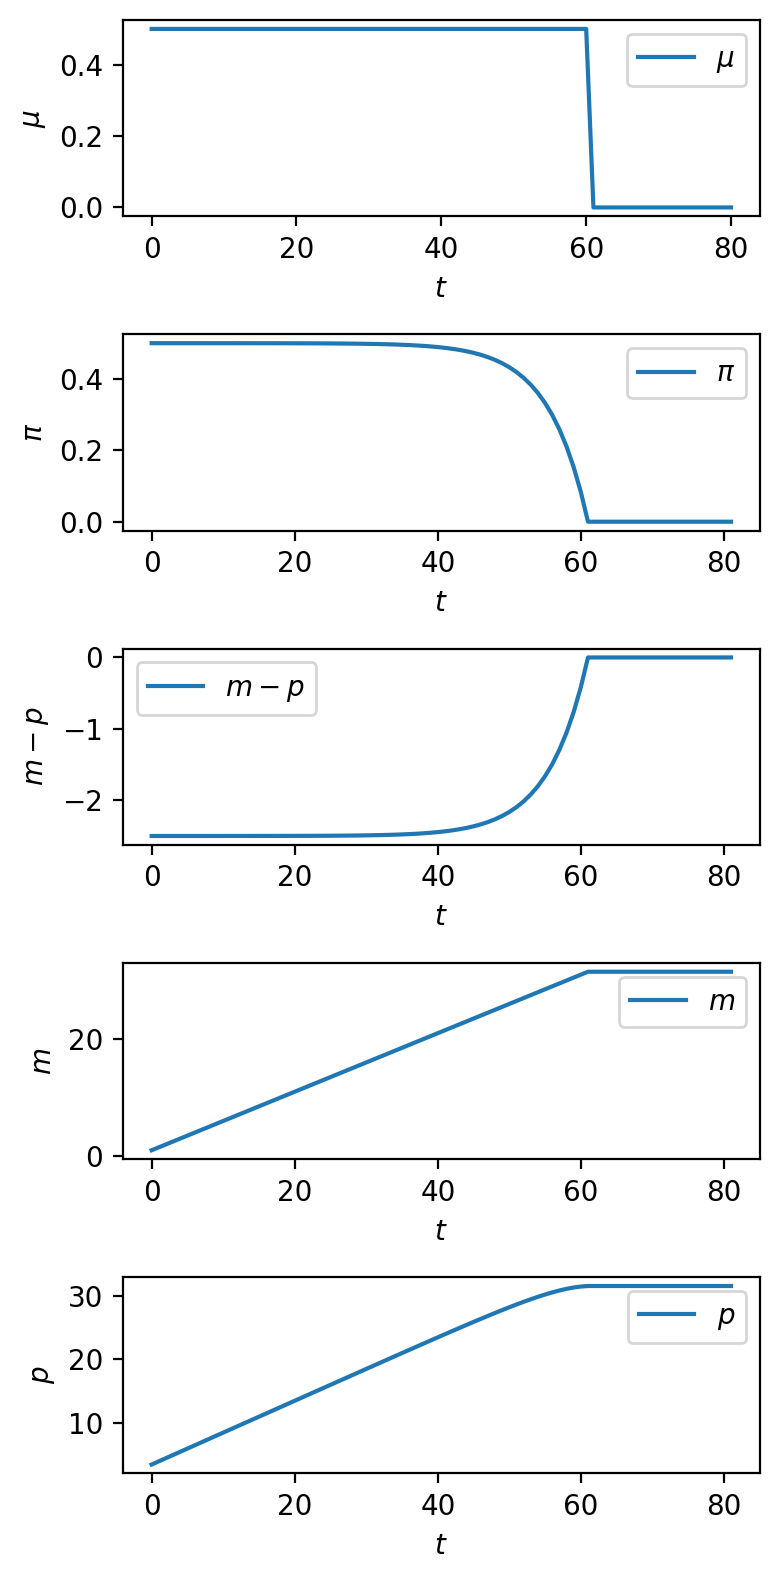

In [29]:
def plot_sequences(sequences, labels):
    _, axs = plt.subplots(len(sequences), 1, figsize=(4, 8), dpi=200)
    for ax, seq, label in zip(axs, sequences, labels):
        ax.plot(range(len(seq)), seq, label=label)
        ax.set_ylabel(label)
        ax.set_xlabel("$t$")
        ax.legend()
    plt.tight_layout()
    plt.show()


sequences = (mu_seq_1, pi_seq_1, m_seq_1 - p_seq_1, m_seq_1, p_seq_1)
plot_sequences(sequences, (r"$\mu$", r"$\pi$", r"$m - p$", r"$m$", r"$p$"))

График темпа роста денежной массы $ \mu_t $ на верхнем графике отображает
резкое снижение с $0.5$ до $0$ в момент времени $T_1 = 60$.

Это приводит к постепенному снижению темпа инфляции $\pi_t$, которое предшествует
снижению темпа роста денежной массы в момент времени $T_1$.

Обратите внимание, как темп инфляции плавно (т.е. непрерывно) снижается до $0$ в момент $T_1$ – в отличие от темпа роста денежной массы, он не «скачет» вниз внезапно в момент $T_1$.

Это связано с тем, что снижение $\mu$ в момент $T_1$ было предсказано с самого начала.

В то время как логарифм денежной массы, изображенный на нижней панели, имеет излом в момент $T_1$, логарифм уровня цен не имеет излома – он «плавный» – опять же, следствие того, что
снижение $\mu$ было предсказано.

### Эксперимент 2: непредвиденная резкая

Откажемся от нашего предположения о «совершенном предвидении», предположив, что внезапное постоянное сокращение $\mu_t$ совершенно *неожиданно*.

Мысленный эксперимент включает переключение в момент времени $T_1$ с первоначальной траектории для $\{\mu_t, \pi_t\}$ на другую, предполагающую постоянно более низкий уровень инфляции.

**Изначальная траектория:** $\mu_t = \mu_0, \forall t \geqslant 0$, то есть имеем последовательность объемов денежной массы $\{\mu_t\}_{t=0}^\infty$; соответствующая траектория инфляции равна $\pi_t = \mu_0$.

**Измененная траектория:** $\mu_0>\mu^*$, $\{\mu_s\}_{s=T_1}^\infty$ строится путем
$\mu_s = \mu^*, \forall s \geqslant T_1$. Траектория совершенного предвидения для $\pi$ --- это $\pi_s = \mu^*$.

Чтобы зафиксировать \<\<совершенно непредвиденный\>\> шок процесса $\{\mu_t\}$ в момент времени $T_1$, мы просто склеиваем $\mu_t, \pi_t$,
полученные на новой траектории $t \geq T_1$, с $\mu_t, \pi_t$, полученными для $t=0, \ldots, T_1 - 1$.

Таким образом, для пути 1 $\pi_t = \mu_0$ для всех $t \in [0, T_1-1]$, тогда как для пути 2 $\mu_s = \mu^*$ для всех $s \geq T_1$.

In [30]:
# path 1
mu_seq_2_path1 = mu0 * np.ones(T + 1)

cm1 = create_cagan_model(mu_seq=mu_seq_2_path1)
pi_seq_2_path1, m_seq_2_path1, p_seq_2_path1 = solve(cm1, T)

# continuation path
mu_seq_2_cont = mu_star * np.ones(T - T1)

cm2 = create_cagan_model(m0=m_seq_2_path1[T1 + 1], mu_seq=mu_seq_2_cont)
pi_seq_2_cont, m_seq_2_cont1, p_seq_2_cont1 = solve(cm2, T - 1 - T1)


# regime 1 - simply glue pi_seq, mu_seq
mu_seq_2 = np.concatenate((mu_seq_2_path1[: T1 + 1], mu_seq_2_cont))
pi_seq_2 = np.concatenate((pi_seq_2_path1[: T1 + 1], pi_seq_2_cont))
m_seq_2_regime1 = np.concatenate((m_seq_2_path1[: T1 + 1], m_seq_2_cont1))
p_seq_2_regime1 = np.concatenate((p_seq_2_path1[: T1 + 1], p_seq_2_cont1))

# regime 2 - reset m_T1
m_T1 = (m_seq_2_path1[T1] + mu0) + cm2.alpha * (mu0 - mu_star)

cm3 = create_cagan_model(m0=m_T1, mu_seq=mu_seq_2_cont)
pi_seq_2_cont2, m_seq_2_cont2, p_seq_2_cont2 = solve(cm3, T - 1 - T1)

m_seq_2_regime2 = np.concatenate((m_seq_2_path1[: T1 + 1], m_seq_2_cont2))
p_seq_2_regime2 = np.concatenate((p_seq_2_path1[: T1 + 1], p_seq_2_cont2))

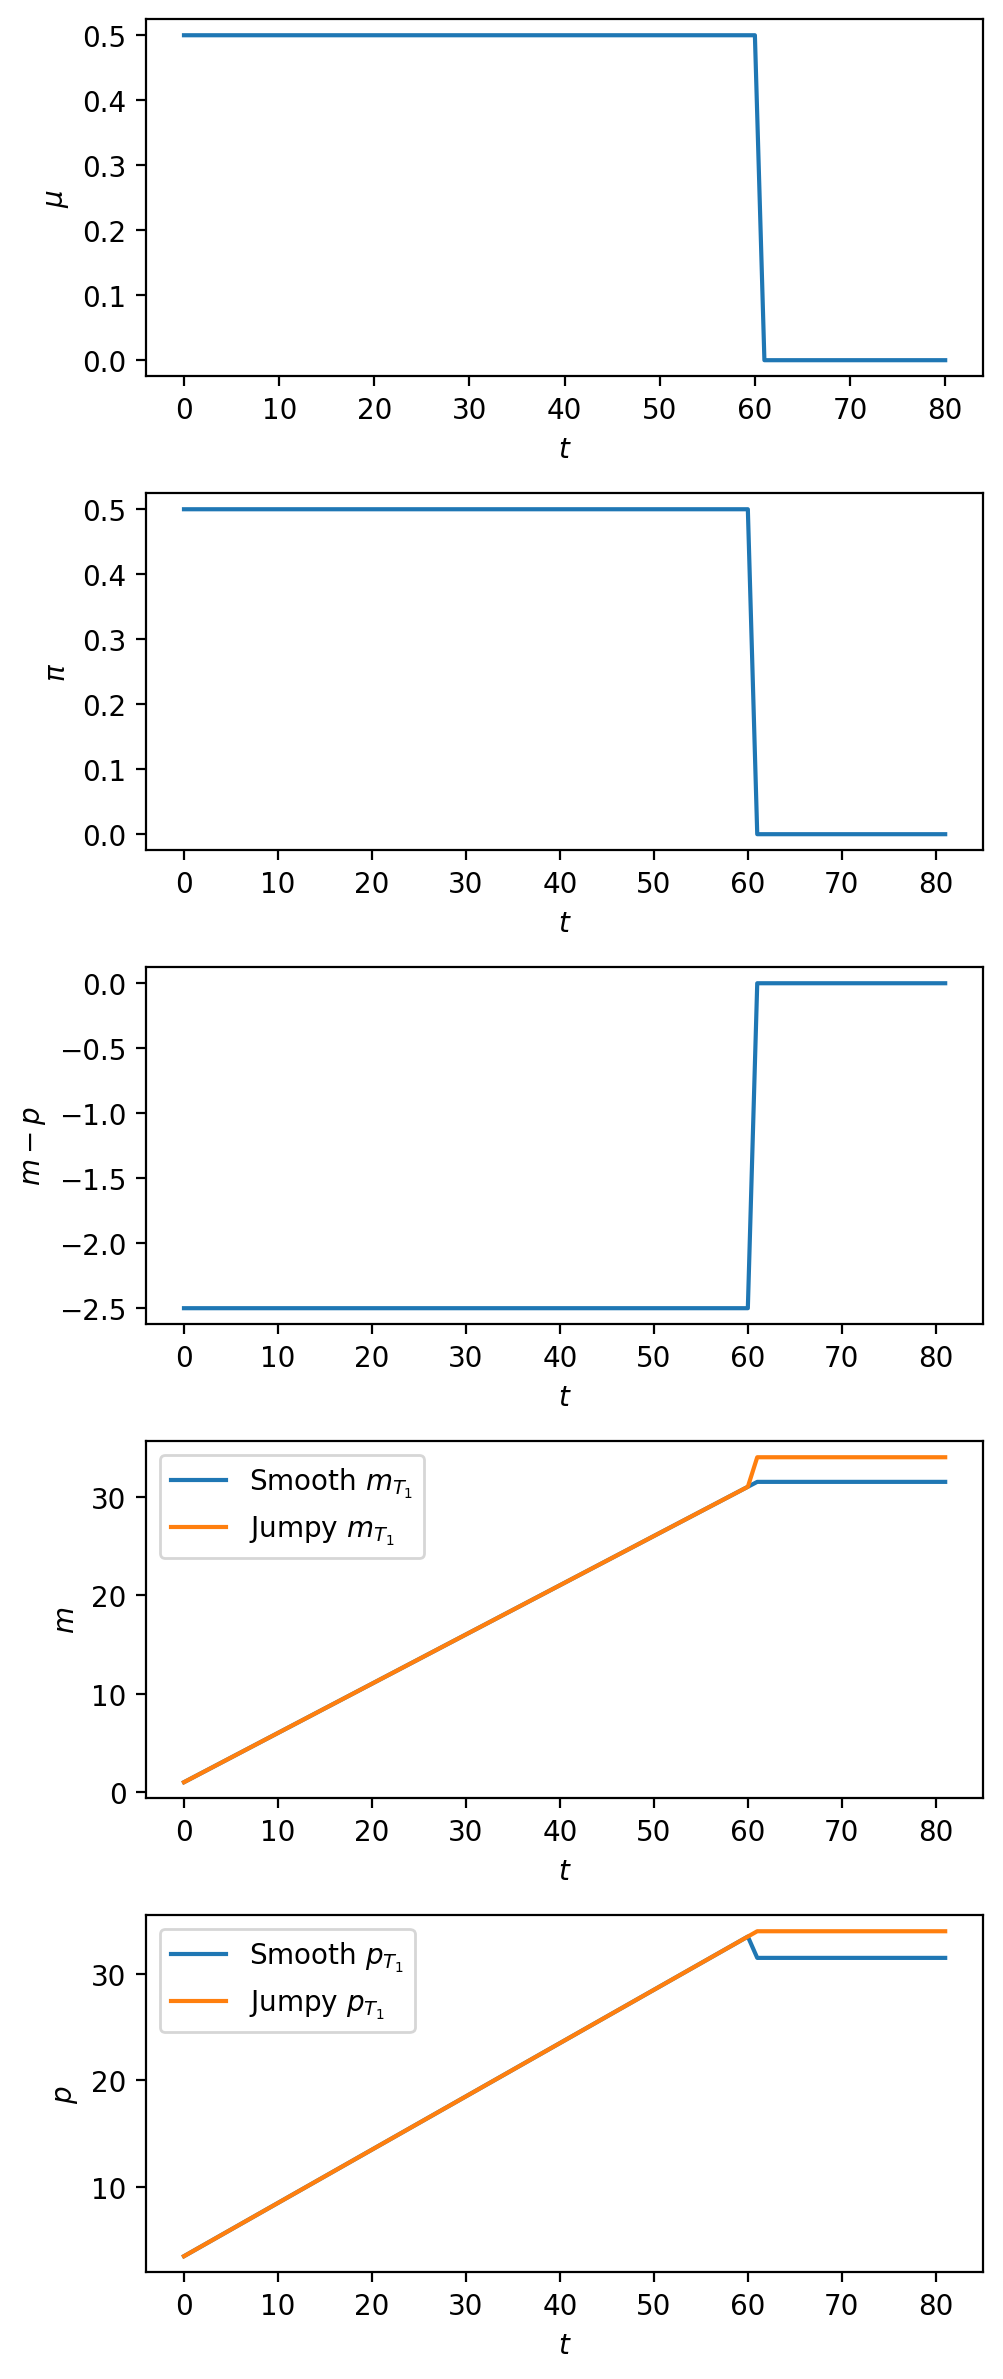

In [31]:
T_seq = range(T + 2)

# plot both regimes
fig, ax = plt.subplots(5, 1, figsize=(5, 12), dpi=200)

# Configuration for each subplot
plot_configs = [
    {"data": [(T_seq[:-1], mu_seq_2)], "ylabel": r"$\mu$"},
    {"data": [(T_seq, pi_seq_2)], "ylabel": r"$\pi$"},
    {"data": [(T_seq, m_seq_2_regime1 - p_seq_2_regime1)], "ylabel": r"$m - p$"},
    {
        "data": [
            (T_seq, m_seq_2_regime1, "Smooth $m_{T_1}$"),
            (T_seq, m_seq_2_regime2, "Jumpy $m_{T_1}$"),
        ],
        "ylabel": r"$m$",
    },
    {
        "data": [
            (T_seq, p_seq_2_regime1, "Smooth $p_{T_1}$"),
            (T_seq, p_seq_2_regime2, "Jumpy $p_{T_1}$"),
        ],
        "ylabel": r"$p$",
    },
]


def experiment_plot(plot_configs, ax):
    # Loop through each subplot configuration
    for axi, config in zip(ax, plot_configs):
        for data in config["data"]:
            if len(data) == 3:  # Plot with label for legend
                axi.plot(data[0], data[1], label=data[2])
                axi.legend()
            else:  # Plot without label
                axi.plot(data[0], data[1])
        axi.set_ylabel(config["ylabel"])
        axi.set_xlabel(r"$t$")
    plt.tight_layout()
    plt.show()


experiment_plot(plot_configs, ax)

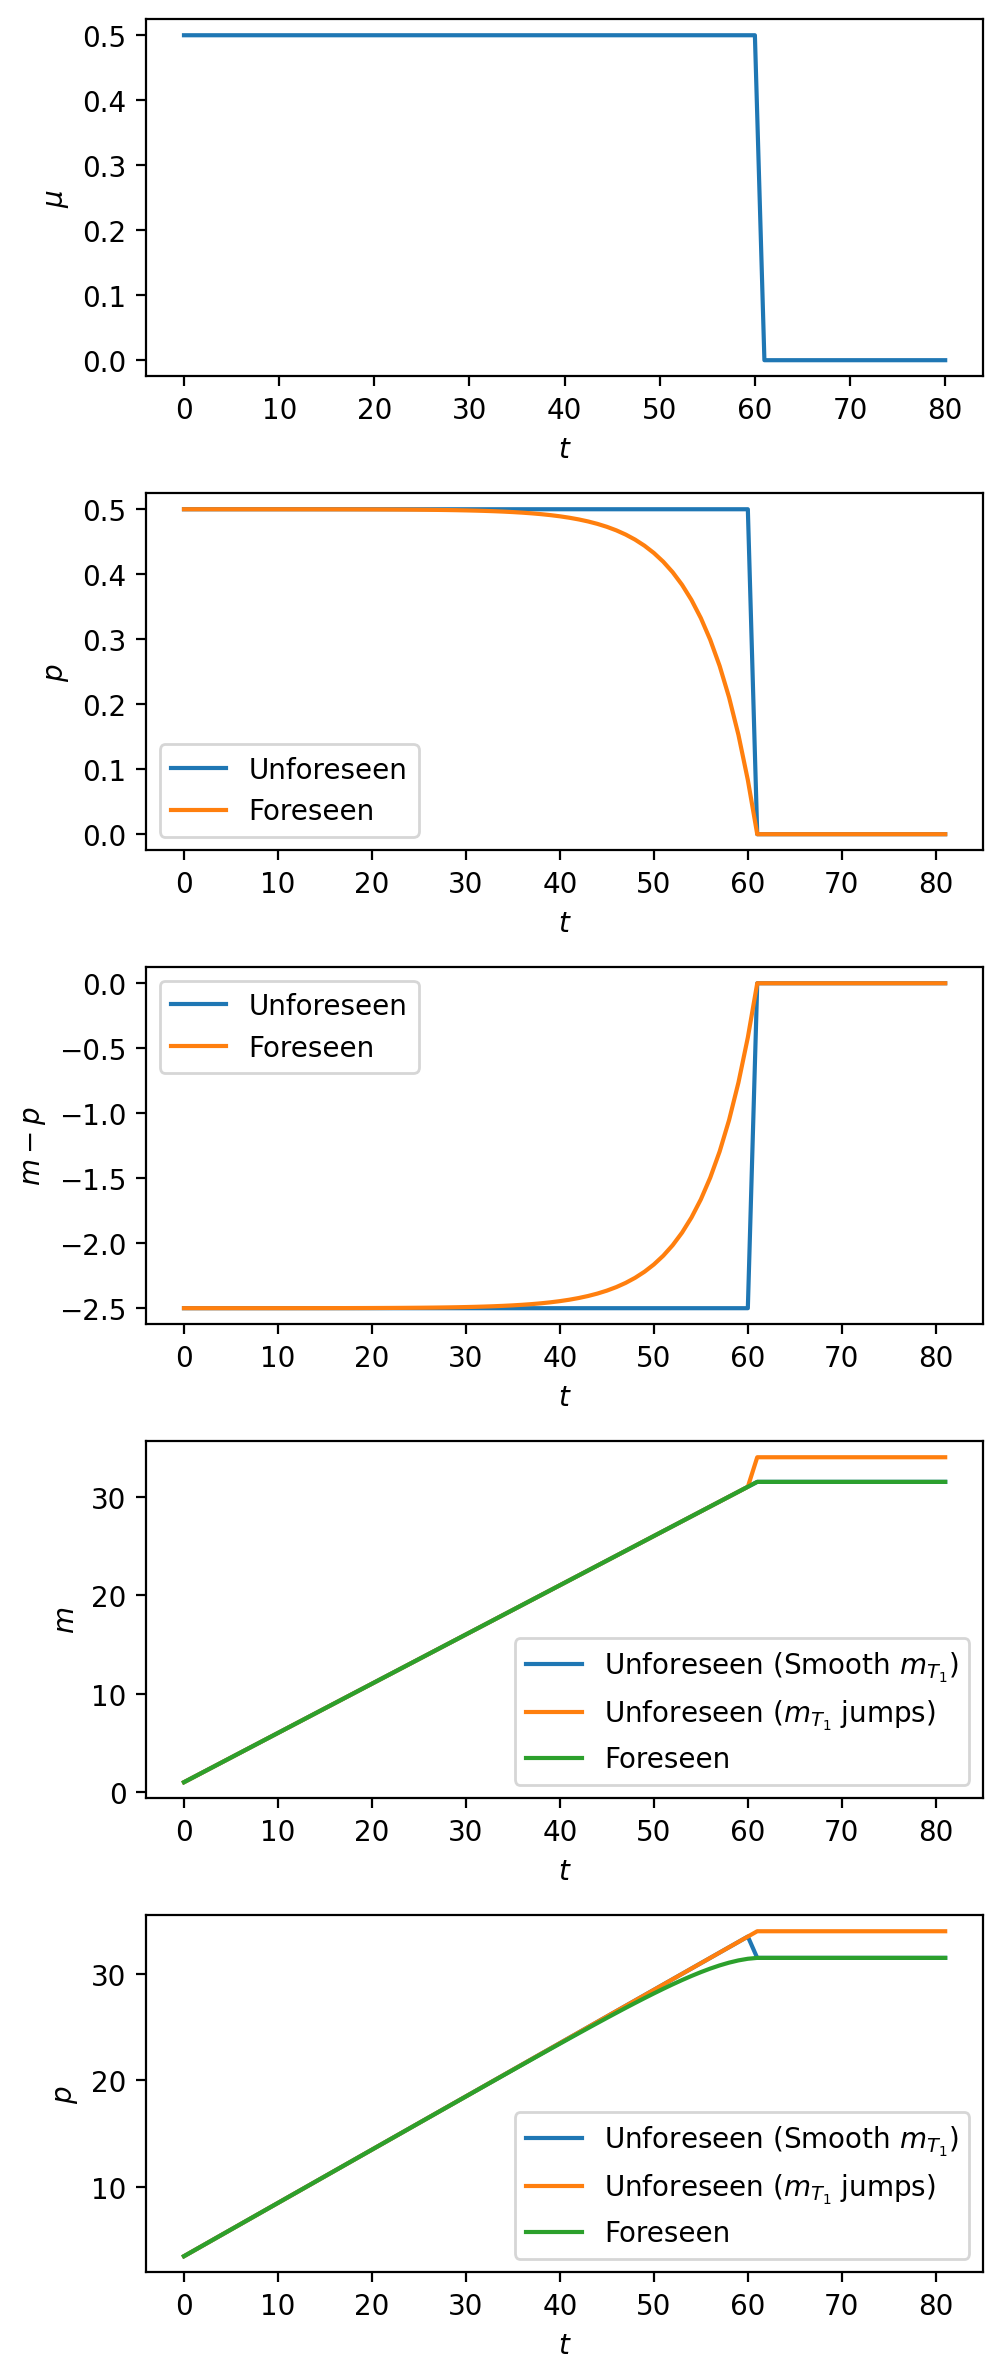

In [32]:
# compare foreseen vs unforeseen shock
fig, ax = plt.subplots(5, figsize=(5, 12), dpi=200)

plot_configs = [
    {"data": [(T_seq[:-1], mu_seq_2)], "ylabel": r"$\mu$"},
    {
        "data": [(T_seq, pi_seq_2, "Unforeseen"), (T_seq, pi_seq_1, "Foreseen")],
        "ylabel": r"$p$",
    },
    {
        "data": [
            (T_seq, m_seq_2_regime1 - p_seq_2_regime1, "Unforeseen"),
            (T_seq, m_seq_1 - p_seq_1, "Foreseen"),
        ],
        "ylabel": r"$m - p$",
    },
    {
        "data": [
            (T_seq, m_seq_2_regime1, "Unforeseen (Smooth $m_{T_1}$)"),
            (T_seq, m_seq_2_regime2, "Unforeseen ($m_{T_1}$ jumps)"),
            (T_seq, m_seq_1, "Foreseen"),
        ],
        "ylabel": r"$m$",
    },
    {
        "data": [
            (T_seq, p_seq_2_regime1, "Unforeseen (Smooth $m_{T_1}$)"),
            (T_seq, p_seq_2_regime2, "Unforeseen ($m_{T_1}$ jumps)"),
            (T_seq, p_seq_1, "Foreseen"),
        ],
        "ylabel": r"$p$",
    },
]

experiment_plot(plot_configs, ax)

# Задание 2: 

Проведите эксперимент, аналогичный проведенному в файле , но для плавного изменения темпов роста денежной массы от 𝜇0 до 𝜇∗.

(Опишите принцип модификации, проведите симуляции и опишите полученные результаты)

## Идея 

Поизучав файлик, место резкого скачка в момент T1 вводим переходный период (T1–T2), где μ линейно снижается от μ0 к μ∗ (что-то похожее на политику ЦБ)

Нам теперь нужна новая последовательнось mu_seq_smooth (принципы)

- если t=0 до T1: μ = μ0 (это обозначает высокую инфляцию) -  thats baaaase
- если t=T2+1 до t=T: μ = μ∗ (стабилизация)
- если t=T1+1 до t=T2: (линейное уменьшение μ от μ0 к μ∗)

Дальше решаем модель через solve() и добавляем сценарий "Smooth" для сравнения с foreseen и unforeseen.


In [33]:
# Стырил из файлика с семинаром 
CaganREE = namedtuple( 
    "CaganREE",
    [
        "m0",      # логарифм денежной массы
        "mu_seq",  # последовательность темпов роста денежной массы
        "alpha",   # чувствительность спроса на реальные остатки денег к ожидаемой инфляции
        "delta",   # вычисляемый параметр из a/(1+a)
        "pi_end",  # финальная инфляция
    ],
)

In [34]:
# конечно же это тоже стырино с файлика с семинаром 

def create_cagan_model(m0=1, alpha=5, mu_seq=None):
    delta = alpha / (1 + alpha)
    pi_end = mu_seq[-1] if mu_seq is not None else None
    return CaganREE(m0, mu_seq, alpha, delta, pi_end)


def solve(model, T):
    m0, pi_end, mu_seq, alpha, delta = (
        model.m0,
        model.pi_end,
        model.mu_seq,
        model.alpha,
        model.delta,
    )
    # Матрицы для решения системы
    A1 = np.eye(T + 1, T + 1) - delta * np.eye(T + 1, T + 1, k=1)
    A2 = np.eye(T + 1, T + 1) - np.eye(T + 1, T + 1, k=-1)
    b1 = (1 - delta) * mu_seq + np.concatenate([np.zeros(T), [delta * pi_end]])
    b2 = mu_seq + np.concatenate([[m0], np.zeros(T)])
    pi_seq = np.linalg.solve(A1, b1)
    m_seq = np.linalg.solve(A2, b2)
    # НЕ НЕ НЕ добавляем лишний элемент! Я потратил 30 минут жизни, чтобы отыскать это...
    p_seq = m_seq + alpha * pi_seq
    return pi_seq, m_seq, p_seq

In [35]:
def experiment_plot(plot_configs, ax):
    for i, config in enumerate(plot_configs):
        for data in config["data"]:
            if len(data) == 2:
                t, y = data
                label = None
            else:
                t, y, label = data
            ax[i].plot(t, y, label=label, linewidth=2)
            ax[i].set_ylabel(config["ylabel"], fontsize=12)
            ax[i].grid(True, linestyle='--', alpha=0.7)
            if "xlim" in config:
                ax[i].set_xlim(config["xlim"])
            if label:
                ax[i].legend(fontsize=10)
    ax[-1].set_xlabel("Time", fontsize=12)
    plt.tight_layout()
    plt.show()

In [36]:
# Параметры эксперимента
T1 = 60
mu0 = 0.5
mu_star = 0
T = 80
T2 = 70  # конец плавного перехода

In [37]:
# Последовательности для разных сценариев
mu_seq_1 = np.append(mu0 * np.ones(T1 + 1), mu_star * np.ones(T - T1))  # резкий скачок

mu_smooth_transition = np.linspace(mu0, mu_star, T2 - T1 + 1)
mu_seq_smooth = np.concatenate([
    mu0 * np.ones(T1 + 1),
    mu_smooth_transition[1:],
    mu_star * np.ones(T - T2)
])
# Проверка длины
print(len(mu_seq_smooth), T+1)

81 81


In [38]:
# Модели
cm_foreseen = create_cagan_model(mu_seq=mu_seq_1)
cm_smooth = create_cagan_model(mu_seq=mu_seq_smooth)

In [39]:
# Решения
pi_seq_1, m_seq_1, p_seq_1 = solve(cm_foreseen, T)
pi_seq_smooth, m_seq_smooth, p_seq_smooth = solve(cm_smooth, T)

In [40]:
# Для unforeseen (правильная длина mu_seq_2)
mu_seq_2 = np.concatenate([
    mu0 * np.ones(T1 + 1),
    mu_star * np.ones(T - T1)
])
T_seq = np.arange(T + 1)
cm2 = create_cagan_model(mu_seq=mu_seq_2)
pi_seq_2_regime1, m_seq_2_regime1, p_seq_2_regime1 = solve(cm2, T)

print(len(T_seq), len(mu_seq_smooth), len(pi_seq_1), len(pi_seq_2_regime1), len(pi_seq_smooth)) # олилуйа у меня совпали размерности! ураааааааааа

81 81 81 81 81


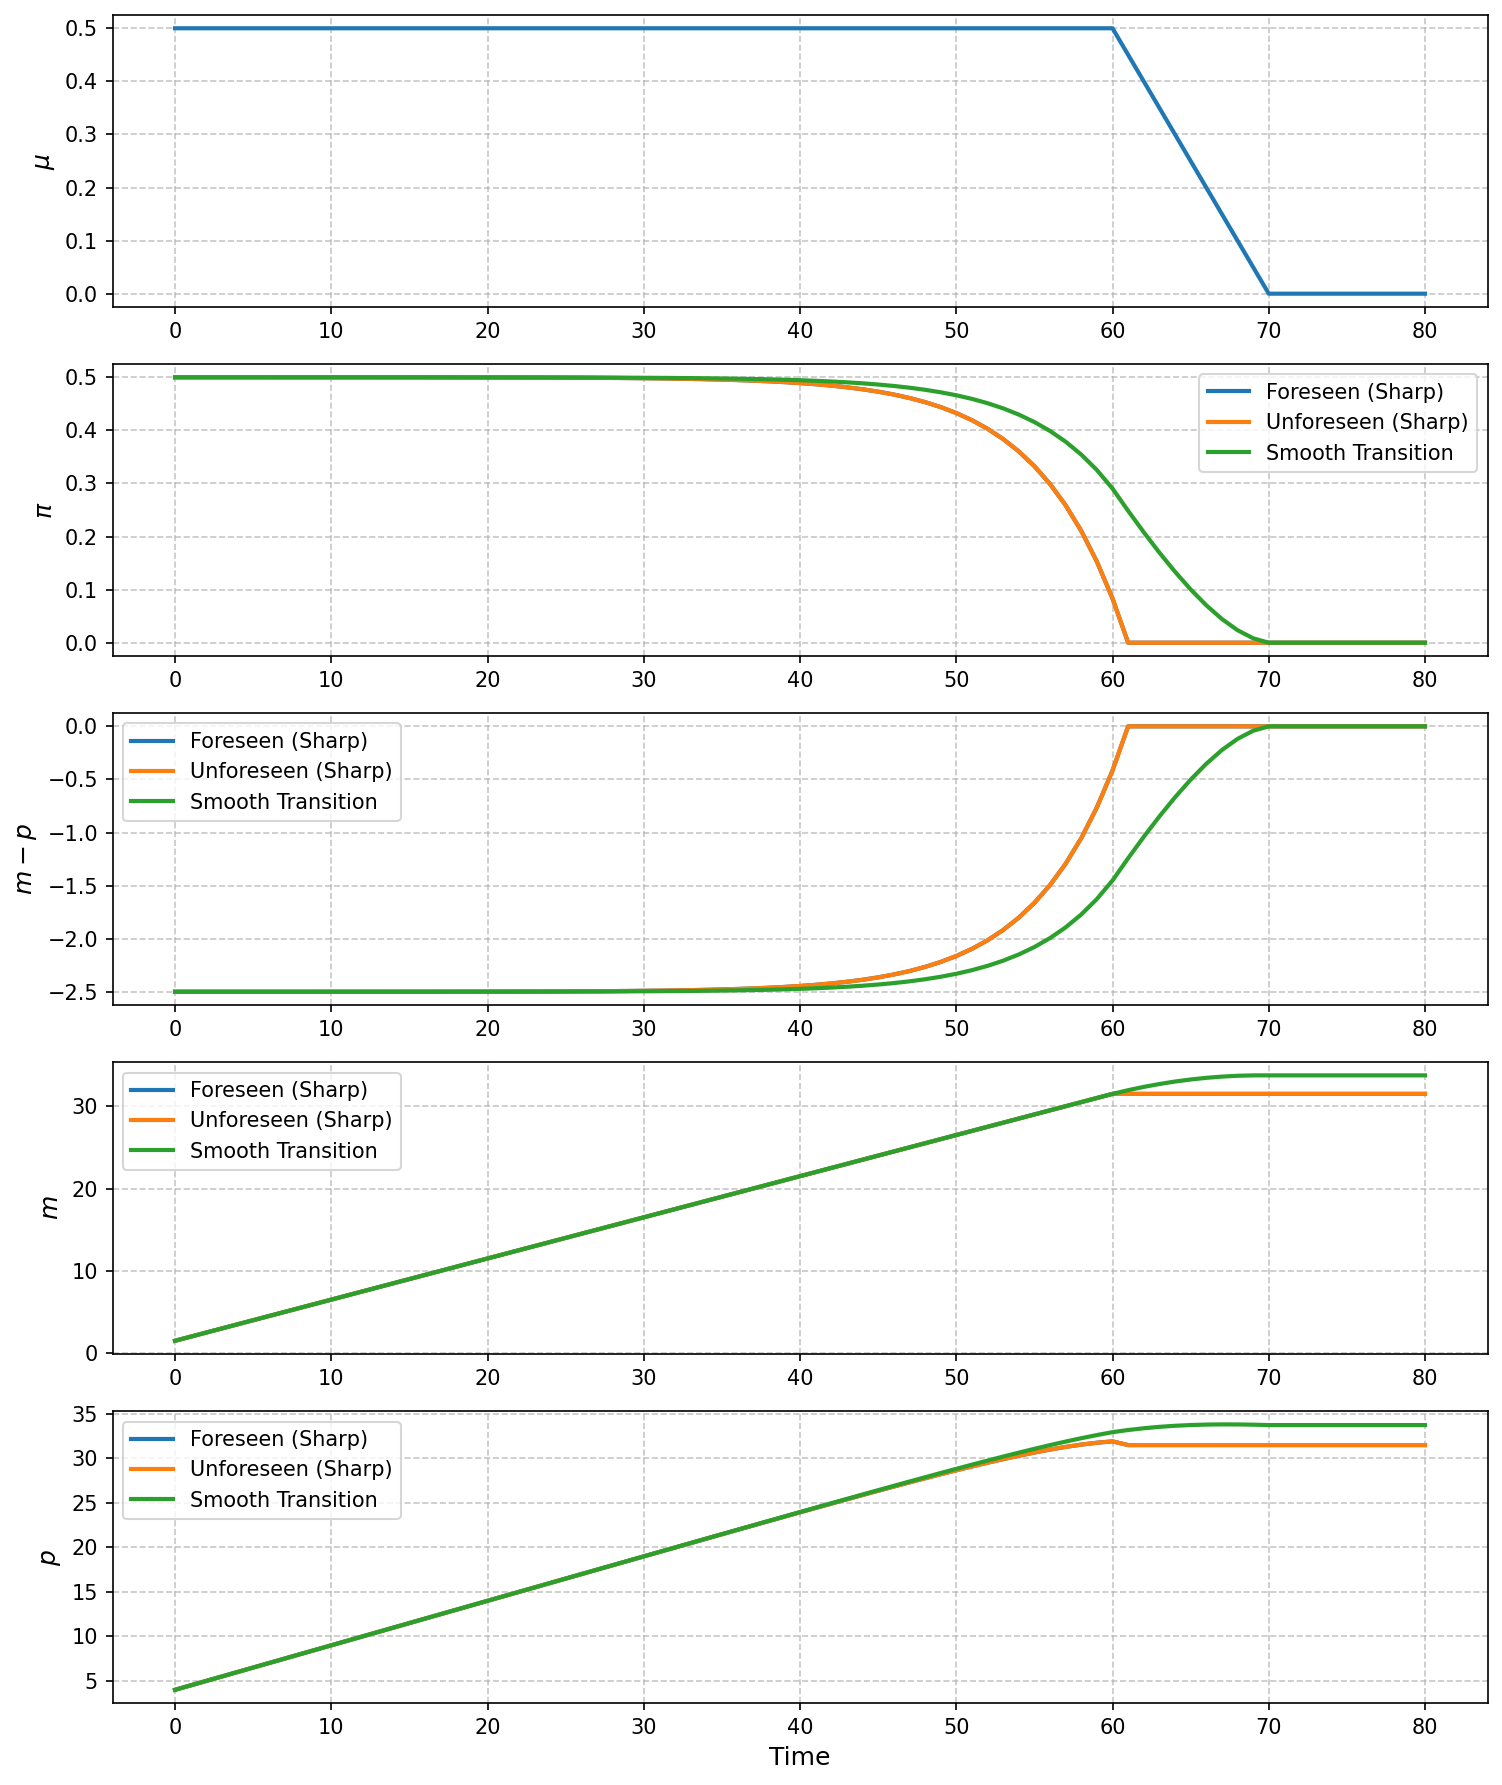

In [41]:
# Графики
fig, ax = plt.subplots(5, figsize=(10, 12), dpi=150)
plot_configs = [
    {"data": [(T_seq, mu_seq_smooth)], "ylabel": r"$\mu$"},
    {
        "data": [
            (T_seq, pi_seq_1, "Foreseen (Sharp)"),
            (T_seq, pi_seq_2_regime1, "Unforeseen (Sharp)"),
            (T_seq, pi_seq_smooth, "Smooth Transition")
        ],
        "ylabel": r"$\pi$",
    },
    {
        "data": [
            (T_seq, m_seq_1 - p_seq_1, "Foreseen (Sharp)"),
            (T_seq, m_seq_2_regime1 - p_seq_2_regime1, "Unforeseen (Sharp)"),
            (T_seq, m_seq_smooth - p_seq_smooth, "Smooth Transition")
        ],
        "ylabel": r"$m - p$",
    },
    {
        "data": [
            (T_seq, m_seq_1, "Foreseen (Sharp)"),
            (T_seq, m_seq_2_regime1, "Unforeseen (Sharp)"),
            (T_seq, m_seq_smooth, "Smooth Transition")
        ],
        "ylabel": r"$m$",
    },
    {
        "data": [
            (T_seq, p_seq_1, "Foreseen (Sharp)"),
            (T_seq, p_seq_2_regime1, "Unforeseen (Sharp)"),
            (T_seq, p_seq_smooth, "Smooth Transition")
        ],
        "ylabel": r"$p$",
    },
]
experiment_plot(plot_configs, ax)


Графики показывают симуляции модели Кейгана, сравнивая три сценария снижения роста денежной массы μ: Foreseen Sharp (синий), Unforeseen Sharp (оранжевый) и Smooth Transition (зелёный). Параметры: T=80, T1=60, T2=70, μ₀=0.5 → μ∗=0, α=5. Время от 0 до 80; для Smooth μ линейно падает с t=60 до t=70.

Панели (сокращённо):

* μ — заданная политика: foreseen/unforeseen — резкий шаг в t≈60; smooth — линейный спад 60–70
* π (инфляция) — следует за μ с лагом: foreseen снижается заранее, unforeseen — резкий спад в 60, smooth — постепенное сглаженное падение
* p (уровень цен) — кумулятивный эффект: разные траектории, все стабилизируются после снижения μ; smooth — без скачков
* m - p (реальные остатки) — растут при падении инфляции; unforeseen показывает скачок (velocity dividend), smooth распределяет эффект во времени
* m — интеграл μ: стабилизация после обнуления μ; smooth — плавный переход

Вывод: Smooth убирает резкие скачки в π, p и m–p, оставляя ту же экономическую логику (инфляция следует за μ, ожидания создают лаги). Графики полностью соответствуют заданию (аналог эксперимента в файле с добавлением gradual сценария).


# Куда ведет кроличья нора?

 Варкалось. Хливкие шорьки

 Пырялись по наве,

 И хрюкотали зелюки,
 
 Как мюмзики в мове.

© Льюис Кэрролл 


Кролики - это не только ценный мех...

Предположим, что вы решили завести себе кроликов и приобрели двух крольчат мужеского и женского пола. Зрелости кролики достигают примерно на 110 день своей жизни, после чего начинают размножаться. Беременность у кроликов длится примерно 30 дней, после чего крольчиха способна вновь забеременеть. Окрол составляет от 4 до 12 крольчат. Срок жизни кролика в природе составляет примерно 3 года.

Для простоты предположим, что число крольчат в окроле всегда одинаково, причем доля кроликов каждого пола постоянна. Также предположим, что в каждый момент кролики образуют жесткие пары.

Составьте модель, позволяющую вам оценить поголовье кроликов. Сколько кроликов будет у вас через 3 года?
Предположим, что жизнь кроликов не безоблачна, и они могут резко заболеть и околеть. Также предположим, что вероятность заболеть зависит от числа кроликов. Введите в модель эту вероятность и еще раз оцените численность кроликов через три года. что поменялось?

## Идея 

Популяция кроликов за 3 года как будет расти, если начать с одной самки и одного самца. В коде мы делим кроликов на группы: маленькие самки, взрослые самки (не беременные), беременные самки, маленькие самцы и взрослые самцы. Код учитывает, что:
- Кролики становятся взрослыми через 110 дней.
- Беременность длится 30 дней, и после родов самка может снова забеременеть.
- В каждом помёте рождается 8 крольчат, половина из которых — самки.
- Размножение зависит от того, сколько пар (взрослых самок и самцов) есть, и не может быть больше, чем пар.
- Новые крольчата добавляются, а старые группы уменьшаются, когда кролики растут или рождаются новые.

В конце код показывает, сколько кроликов будет через 3 года, и рисует график, чтобы показать, как их число менялось со временем - шик блеск 

Поголовье кроликов через 3 года: 309,355,744


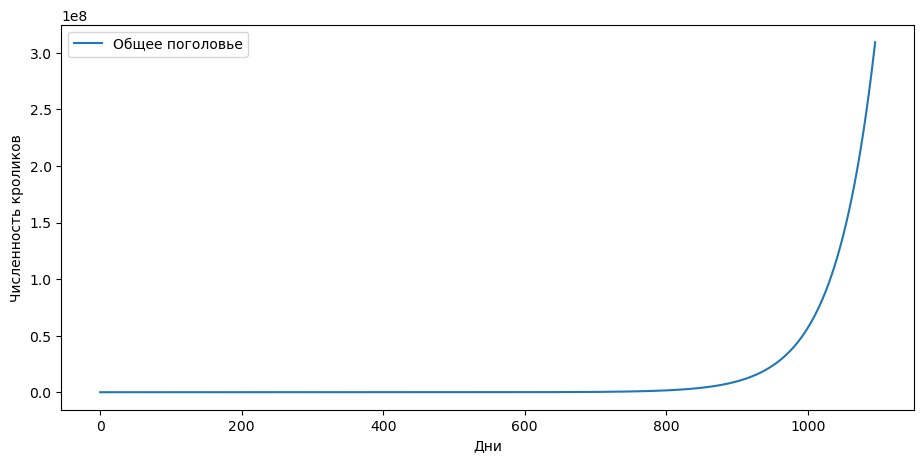

In [42]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11, 5)


lifespan = 3 * 365           # Дней жизни кролика (горизонт моделирования)
maturity_age = 110           # Дней до зрелости
pregnancy_duration = 30      # Дней беременности
litter_size = 8              # Крольчат за раз (можно менять!)
female_ratio = 0.5           # Доля самок

birth_rate = 1 / pregnancy_duration  # Частота родов на беременную самку
days = np.linspace(0, lifespan, lifespan + 1)
def F_rabbits(x, t, params):
    S, E, I, Ms, Me = x
    maturity_age, pregnancy_duration, litter_size, female_ratio, birth_rate = params
    pairs = min(E, Me)

    # Переходы по компартментам
    dS_dt = -S / maturity_age
    dMs_dt = -Ms / maturity_age

    dE_dt = S / maturity_age - birth_rate * pairs
    dMe_dt = Ms / maturity_age

    dI_dt = birth_rate * pairs - birth_rate * I

    # Рождение новых самок и самцов
    births_f = birth_rate * I * litter_size * female_ratio
    births_m = birth_rate * I * litter_size * (1 - female_ratio)

    dE_dt += birth_rate * I
    dS_dt += births_f
    dMs_dt += births_m

    return [dS_dt, dE_dt, dI_dt, dMs_dt, dMe_dt]


def solve_rabbits(litter_size=8):
    S0 = 1.0
    E0 = 0.0
    I0 = 0.0
    Ms0 = 1.0
    Me0 = 0.0
    x0 = [S0, E0, I0, Ms0, Me0]

    params = (maturity_age, pregnancy_duration, litter_size, female_ratio, birth_rate)

    def G(x, t):
        return F_rabbits(x, t, params)

    sol = spi.odeint(G, x0, days)
    S_path, E_path, I_path, Ms_path, Me_path = sol.T
    total_path = S_path + E_path + I_path + Ms_path + Me_path
    return days, S_path, E_path, I_path, Ms_path, Me_path, total_path

days, S, E, I, Ms, Me, total = solve_rabbits(litter_size=8)  

print(f"Поголовье кроликов через 3 года: {total[-1]:,.0f}")

plt.plot(days, total, label="Общее поголовье")
plt.xlabel("Дни")
plt.ylabel("Численность кроликов")
plt.legend()
plt.show()

Без учёта смерти или ограничений среды популяция взлетает до 309 миллионов за 3 года, как видно на графике. Это нереально, потому что в жизни есть факторы вроде старости или нехватки еды, которые замедляют рост. Чтобы сделать модель правдоподобной, нужно добавить смертность и предел для численности, например, 50 миллионов.

Немного проагрейдим 

## Идея 

Код показывает  как будет увеличиваться число кроликов за 3 года, начиная с одной самки и одного самца. Он учитывает, что кролики взрослеют через 110 дней, беременность длится 30 дней, и каждая самка рожает 8 крольчат (матож) (половина — самки) Размножение зависит от пар (взрослые самки и самцы), а если кроликов становится слишком много (до 50 миллионов), рост замедляется. Также код учитывает естественную смерть (через 3 года) и болезни, которые убивают больше кроликов, когда их много

Без болезней через 3 года: 49,986,304 кроликов
С болезнями через 3 года: 572,097 кроликов
Разница: 87.4 раз


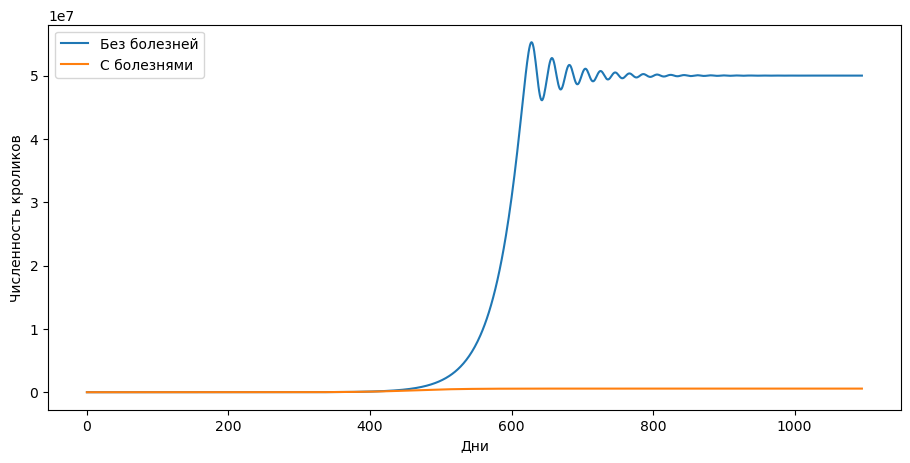

In [ ]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11, 5)
lifespan = 3 * 365           # Дней жизни кролика
maturity_age = 110           # Дней до зрелости
pregnancy_duration = 30      # Дней беременности
litter_size = 8              # Крольчат за раз (среднее из 4-12)
female_ratio = 0.5           # Доля самок
death_rate = 1 / lifespan    # Естественная смертность (1/3 года)
disease_coef = 5e-8          # Коэффициент смертности от болезни (подобран для реализма)
preg_rate_const = 1 / 1      # Скорость зачатия (~1 день)
birth_rate = 1 / pregnancy_duration  # Скорость родов
carrying_capacity = 50e6     # Ограничение среды (50 млн) # условно лужайка закончилась, я понимаю предел должен существовать 
days = np.linspace(0, lifespan, lifespan + 1)

def F_rabbits(x, t, params):
    S, E, I, Ms, Me = x  # S: незрелые самки, E: зрелые не беременные, I: беременные
                         # Ms: незрелые самцы, Me: зрелые самцы
    (
        maturity_age, pregnancy_duration, litter_size, female_ratio,
        preg_rate_const, birth_rate, death_rate, disease_coef, with_disease, carrying_capacity
    ) = params

    total_pop = S + E + I + Ms + Me
    dS_dt = -S / maturity_age
    dMs_dt = -Ms / maturity_age
    preg_rate = preg_rate_const * min(E, Me) * (1 - total_pop / carrying_capacity)  # Логистическое ограничение
    dE_dt = S / maturity_age - preg_rate
    dI_dt = preg_rate - birth_rate * I
    dMe_dt = Ms / maturity_age
    dE_dt += birth_rate * I  # Возврат в E после родов

    births = birth_rate * I * litter_size
    births_f = births * female_ratio  # Новые самки в S
    births_m = births * (1 - female_ratio)  # Новые самцы в Ms

    dS_dt += births_f
    dMs_dt += births_m

    dS_dt -= death_rate * S
    dE_dt -= death_rate * E
    dI_dt -= death_rate * I
    dMs_dt -= death_rate * Ms
    dMe_dt -= death_rate * Me

    # Смертность от болезни 
    if with_disease:
        per_capita_disease = disease_coef * total_pop
        dS_dt -= per_capita_disease * S
        dE_dt -= per_capita_disease * E
        dI_dt -= per_capita_disease * I
        dMs_dt -= per_capita_disease * Ms
        dMe_dt -= per_capita_disease * Me

    return [dS_dt, dE_dt, dI_dt, dMs_dt, dMe_dt]


def solve_rabbits(with_disease=False):
    # Начальные условия: 1 незрелая самка, 1 незрелый самец
    S0 = 1.0  # Незрелые самки
    E0 = 0.0  # Зрелые самки
    I0 = 0.0  # Беременные самки
    Ms0 = 1.0  # Незрелые самцы
    Me0 = 0.0  # Зрелые самцы
    x0 = [S0, E0, I0, Ms0, Me0]

    params = (
        maturity_age, pregnancy_duration, litter_size, female_ratio,
        preg_rate_const, birth_rate, death_rate, disease_coef, with_disease, carrying_capacity
    )

    sol = spi.odeint(F_rabbits, x0, days, args=(params,))
    S_path, E_path, I_path, Ms_path, Me_path = sol.T
    females_path = S_path + E_path + I_path
    males_path = Ms_path + Me_path
    total_path = females_path + males_path
    return days, females_path, males_path, total_path

def plot_rabbit_paths(paths, labels, times):
    fig, ax = plt.subplots()
    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)
    ax.set_xlabel("Дни")
    ax.set_ylabel("Численность кроликов")
    ax.legend()
    plt.show()

# --- Симуляции ---
days, females_no, males_no, total_no = solve_rabbits(with_disease=False)
days, females_d, males_d, total_d = solve_rabbits(with_disease=True)

# Вывод результатов
print(f"Без болезней через 3 года: {total_no[-1]:,.0f} кроликов")
print(f"С болезнями через 3 года: {total_d[-1]:,.0f} кроликов")
print(f"Разница: {total_no[-1] / total_d[-1]:.1f} раз")

# --- Графики ---
plot_rabbit_paths(
    [total_no, total_d],
    ["Без болезней", "С болезнями"],
    days
)

Этот код и график демонстрируют, как популяция кроликов растёт за 3 года, начиная с одной самки и одного самца. Без болезней число кроликов взлетает почти до 50 миллионов благодаря быстрому размножению и ограничению (лужайка не вечная) (8 крольчат за 30 дней), хотя естественная смерть (через 3 года) и лимит в 50 миллионов немного сдерживают рост. С учётом болезней популяция резко сокращается до 572,097 кроликов, так как дополнительная смертность, зависящая от численности, сильно подавляет рост. Разница в 87 раз подчёркивает, насколько болезни влияют на численность, показывая, что без них кролики могли бы значительно больше размножаться.